# D&D Statistic Routines

## TO DO
- Add argument for a flat dmg modifier that is added some percentage of the time (e.g. rage damage bonus)
- Add arguments for half-proficiency and double-proficiency in the ability check function
- Do a chart which shows the percentage point benefit from advantage, and then a chart which translates that to a +modifier that you get from advantage.  For example a check against a DC 13 challenge has a 40% chance of succeeding (ignoring criticals for now).  At advantage, that check has a 64% chance of succeeding (for a 24 ppt gain).  That translates into a +5 roll equivalent which is ceiling(0.24/0.05, ceiling_accuracy) where I used ceiling_accuracy at 0.25 to round to the next highest quarter of a point modifier.

In [1]:
from itertools import product, combinations, combinations_with_replacement, permutations, zip_longest
from functools import reduce
from statistics import mean
import collections
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import doctest
#import scipy

In [2]:
import time, collections, functools

######################################################################
######### Utility functions
######################################################################

def decorator(d):
    """Make function d a decorator: d wraps a function fn.
    Note that update_wrapper just makes sure the docstring and args list
    in help(fn) point to the right place"""
    def _d(fn):
        return functools.update_wrapper(d(fn), fn)
    functools.update_wrapper(_d, d)
    return _d

@decorator
def memoize(f):
    """Decorator that caches the return value for each call to f(args).
    Then when called again with same args, we can just look it up."""
    cache = {}
    def _f(*args, **kwargs):
        try:
            # I need to make args and kwargs hashable to be able to use as a key
            # in the cache dictionary.  Other dicts are not hashable, so by default
            # kwargs is not hashable, but frozenset(dict.items()) makes it hashable
            # as long as values within the dict are all hashable.
            return cache[(args, frozenset(kwargs.items()))]
        except KeyError:
            cache[(args, frozenset(kwargs.items()))] = result = f(*args, **kwargs)
            return result
        except TypeError:
            # some element of args can't be a dict key
            # print(f'{_f.__name__} had type error in memoize: \nargs:\n{args}\nkwargs\n{kwargs}')
            return f(*args, **kwargs)
    return _f

@decorator
def trace(f):
    '''A decorator which prints a debugging trace every time the
    decorated function is called.  It handles recursion with
    indented print statements'''
    indent = '|    '
    def _f(*args, **kwargs):
        signature = f'{f.__name__}({", ".join(map(repr, args))} {", ".join([str(k)+"="+str(v) for k, v in kwargs.items()])})'  
        print(f'{trace.level*indent}|--> {signature}')
        trace.level += 1
        try:
            # your code here
            result = f(*args, **kwargs)
            print(f'{(trace.level-1)*indent}|  < {signature} == {result}')  
        finally:
            trace.level -= 1
        return result
    trace.level = 0
    return _f

def disabled(f): return f
#trace = disabled

def timedcall(fn, *args, **kwargs):
    "Call function with args; return the time in seconds and result."
    t0 = time.perf_counter()
    result = fn(*args, **kwargs)
    t1 = time.perf_counter()
    return t1-t0, result

def average(numbers):
    "Return the average (arithmetic mean) of a sequence of numbers."
    return sum(numbers) / float(len(numbers))

def timedcalls(n, fn, *args, **kwargs):
    """Call fn(*args) repeatedly: n times if n is an int, or up to
    n seconds if n is a float; return the min, avg, and max time"""
    if isinstance(n, int):
        times = [timedcall(fn, *args, **kwargs)[0] for _ in range(n)]
    else:
        times = []
        total = 0.0
        while total < n:
            t = timedcall(fn, *args, *kwargs)[0]
            total += t
            times.append(t)
    return min(times), average(times), max(times)


In [3]:
@memoize
def tester(a, b=(20,)):
    return sum([a*b_item for b_item in b])

print(f"{tester(3)=}")
print(f"{tester(3, b=(1,2))=}")

tester(3)=60
tester(3, b=(1,2))=9


In [4]:
d4 = list(range(1,5))
d6 = list(range(1,7))
d8 = list(range(1,9))
d10 = list(range(1,11))
d12 = list(range(1,13))
d20 = list(range(1,21))
d100 = list(range(1,101))

In [5]:
# thinking through average roll values
twodie = list(product(d4,repeat=2))
twodie_totals = [sum(pair) for pair in twodie]
print("{}\n{}".format(twodie, twodie_totals))
print(mean(twodie_totals))

# All in one statement:
mean([sum(pair) for pair in product(d4, repeat=2)])

[(1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (3, 1), (3, 2), (3, 3), (3, 4), (4, 1), (4, 2), (4, 3), (4, 4)]
[2, 3, 4, 5, 3, 4, 5, 6, 4, 5, 6, 7, 5, 6, 7, 8]
5


5

# Monster AC distribution by PC level

In [6]:
# Read a file with the distribution of monster AC's at any given PC level. 
#    This uses all (or a majority) of the monsters from official D&D
#    sources and assumes that PC's fight monster CRs in the range of 
#    pc_lvl - 5 <= CR <= pc_lvl + 2


# ac = (pd.read_csv('monster_ac_distro.csv', header=1)
#         .set_index('PC Level')
#         .rename_axis('Monster AC', axis='columns')
#      )
# ac

# Diceroll Odds Major functions

In [7]:
@memoize
def possible_rolls(die, n=1, adv='normal'):
    '''
    possible_rolls
    Returns a list of tuples of all possible rolls of dice given the die type ('die') and number 
    of dice rolled ('n').  Each tuple represents one possible roll of 'n' dice of type 'die'
    
    Arguments
    die = integer specifying which die type is used for the roll (e.g. 6 = d6)
    n = integer specifying how many of the 'die' type dice are rolled.
    adv = a string of 'nor', 'adv', or 'dis'. Specifies whether the attack roll is 
          made normally, with advantage, or with disadvantage.  If 'adv' or 'dis'
          are specified, n will be forced to 2 or n, whichever is higher and the resulting list of 
          tuples will have tuples of len=1.
          
    >>> possible_rolls(4, n=2)
    [(1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (3, 1), (3, 2), (3, 3), (3, 4), (4, 1), (4, 2), (4, 3), (4, 4)]
    '''
    if adv.lower().startswith('nor'):
        dice_rolls = list(product(list(range(1,die+1)), repeat=n))
        return dice_rolls
    elif adv.lower().startswith('adv'):
        dice_rolls = list(product(list(range(1,die+1)), repeat=max(n,2)))
        return [(max(rolls),) for rolls in dice_rolls]
    elif adv.lower().startswith('dis'):
        dice_rolls = list(product(list(range(1,die+1)), repeat=max(n,2)))
        return [(min(rolls),) for rolls in dice_rolls]
    else:
        raise ValueError("Invalid argument to possible_rolls: adv={}".format(adv))
        

def reroll_on_x(roll_list, die, x=(1,), debug=False):
    '''Takes in a list of rolls.  Returns a dictionary of possible rolls (the key) and the 
    odds of getting that role (the value).
    
    Arguments:
    roll_list: a list of tuples representing rolls of dice of type 'die'.  Each roll is a tuple.
    die = integer specifying which die type is used for the roll (e.g. 6 = d6)
    x = tuple of integers representing values which should be re-rolled and replace with all possible
        results of the re-roll.  For example if one of the rolls inside roll_list is (1, 6) and 'x'=(1,)
        and 'die'=6, then the (1,6) entry will be replace with (1,6), (2,6), (3,6), (4,6), (5,6), (6,6).
        I.e. the roll is replaced with all possible outcomes of re-rolling the 1.
        
    This recognizes that rolling a d4 and re-rolling 1s results in the following:
    4 = 25% odds
    3 = 25% odds
    2 = 25% odds
    {1,2,3,4} = split the remaining 25% odds based on the re-roll of the 1.
    Adding this up, it is 6.25% odds of a 1, and 31.25% odds of 2, 3, and 4.
    
    The previous way I was doing this, would not result in these odds, but these are the correct odds.
    >>> test = reroll_on_x(possible_rolls(4), 4)
    >>> sum(test.values())
    1.0
    >>> for k in sorted(test):
    ...     print("({}: {}) ".format(k, test[k]), end='')
    ((1,): 0.0625) ((2,): 0.3125) ((3,): 0.3125) ((4,): 0.3125) 
    >>> test[(1,)]
    0.0625
    >>> test[(2,)]
    0.3125
    >>> test[(3,)]
    0.3125
    >>> test[(4,)]
    0.3125
    >>> test = reroll_on_x(possible_rolls(2, n=2), 2, x=(1,))
    >>> sum(test.values())
    1.0
    >>> for k in sorted(test):
    ...     print("({}: {}) ".format(k, test[k]), end='')
    ((1, 1): 0.125) ((1, 2): 0.1875) ((2, 1): 0.1875) ((2, 2): 0.5) 
    >>> test[(1,1)]
    0.125
    >>> test[(1,2)]
    0.1875
    >>> test[(2,1)]
    0.1875
    >>> test[(2,2)]
    0.5
    '''
    odds = {roll: 0 for roll in set(roll_list)}
    for roll in set(roll_list):
        odds[roll] = roll_list.count(roll)/len(roll_list)
    original_odds = odds.copy()
    odds_adders = {roll: 0 for roll in roll_list} # all zeros for now, we'll accumulate adds here
    for roll in odds.keys():
        if debug: print("On roll: {}, odds={}, odds_adders={}".format(roll, odds, odds_adders)) #debug
        if sum([1 for r in roll if r in x]) > 0:
            odds[roll] = 0
            if debug: print("    zeroing out {}, odds={}".format(roll, odds))
            for i, die_result in enumerate(roll):
                if die_result in x:
                    split_odds = original_odds[roll] / (sum([list(roll).count(element) for element in x]) * die)
                    if debug: print("    rerolling {}th element ({}), split will be {} ways".format(i, die_result, sum([list(roll).count(element) for element in x]) * die))  #debug
                    new_rolls = possible_rerolls(roll, i, die)
                    for nr in new_rolls:
                        if debug: print("        adding {} to {}".format(split_odds, nr)) #debug
                        odds_adders[nr] += split_odds
    
    return {k: v+odds_adders[k] for k, v in odds.items()}


def possible_rerolls(roll, i, die):
    '''Returns a list of tuples representing all the possible ways to re-roll the 
    ith element of "roll" using a "die" type die'''
    return_rolls = []
    for new_die_result in range(1,die+1):
        new_roll = list(roll).copy()
        new_roll[i] = new_die_result
        return_rolls.append(tuple(new_roll))
    return return_rolls
                           
        
def roll_odds(die, n=1, adv='normal', reroll_nums=()):
    '''
    Returns a dictionary with every possible role (in a tuple) as the key and the odds
    of rolling that roll as the value.

    Arguments
    die = integer specifying which die type is used for the roll (e.g. 6 = d6)
    n = integer specifying how many of the 'die' type dice are rolled.
    adv = One of the following two options:
        1) a string of 'nor', 'adv', or 'dis'. Specifies whether the attack roll is 
          made normally, with advantage, or with disadvantage.  If 'adv' or 'dis'
          are specified, n will be forced to 2 or n, whichever is higher and the resulting list of 
          tuples will have tuples of len=1.
        2) a dictionary with keys 'nor', 'adv' & 'dis' and values as floats which denote the percent
           of attacks made with the corresponding advantage.  The values should add to 1.
           Example: {'adv':.2, 'nor':.7, 'dis':.1}.  If specified in this way, the chance returned
           is the weighted average chance to hit given the mix of roll types specified.
    reroll_nums = a list of integers which are values which will be rerolled once if rolled.  Does
                  not check to see if these values are valid for "die" type dice.  default=()

    >>> round(roll_odds(4, n=2)[(3, 2)], 4)
    0.0625
    '''
    if isinstance(adv, dict):
        norm_rolls = reroll_on_x(possible_rolls(die, n=n, adv='nor'), die, x=reroll_nums)
        adv_rolls = reroll_on_x(possible_rolls(die, n=n, adv='adv'), die, x=reroll_nums)
        dis_rolls = reroll_on_x(possible_rolls(die, n=n, adv='dis'), die, x=reroll_nums)
        weighted_odds = {
            roll:
            (norm_rolls[roll] * adv['nor']) +
            (adv_rolls[roll] * adv['adv']) +
            (dis_rolls[roll] * adv['dis'])
            for roll in norm_rolls.keys()
        }
        return weighted_odds
    else:  # adv is a string
        return reroll_on_x(possible_rolls(die, n=n, adv=adv), die, x=reroll_nums)

def merge_roll_odds(roll_odds1, roll_odds2, merged_percentage=1):
    '''Takes two dictionaries of roll_odds in the form: {rolltotal: odds_of_getting_rolltotal}
    and returns a new roll_odds dictionary which represents the odds of totals if one roll_odds
    is added to the other.  
    Arguments:
        roll_odds1:  a total_table for the first roll
        roll_odds2:  a total table for the second roll
        merged_percentage: The percent of time that roll2 is used and added to roll1 
            (roll1 is always used and so is used alone 1 minus this value and merged this value)
    For example: 
        roll_odds1 might be the roll_odds of 2 d4s for scimitar damage and
        roll_odds2 might be the roll_odds of 1 d6 for the sneak attack damage adder that a rogue adds.
        The output in this case would be a roll_odds table for 2d4 + 1d6.
        In this example, if you estimate that the rogue will only get sneak attack 25% of the time
        then specify merged_percentage=.25 and this will return the weighted average of the 
        roll1 used alone 75% of the time and the roll1+roll2 merged 25% of the time.
    >>> rollodds6 = total_odds(6)
    >>> rollodds4 = total_odds(4)
    >>> round(merge_roll_odds(rollodds6, rollodds4)[2],5)
    0.04167
    >>> rollodds2d4 = total_odds(4, n=2)
    >>> round(merge_roll_odds(rollodds6, rollodds2d4)[3],7)
    0.0104167
    >>> round(merge_roll_odds(rollodds6, rollodds2d4)[4],7)
    0.03125
    >>> rolloddsd2 = total_odds(2, n=1)
    >>> merge_roll_odds(rolloddsd2, rolloddsd2, merged_percentage=.25)
    defaultdict(<class 'int'>, {1: 0.375, 2: 0.4375, 3: 0.125, 4: 0.0625})
    '''
    if merged_percentage == 0:
        return roll_odds1
    from collections import defaultdict
    merged_roll_odds = defaultdict(int)
    for sum1, odds1 in roll_odds1.items():
        for sum2, odds2 in roll_odds2.items():
            merged_roll_odds[sum1+sum2] += odds1 * odds2
    if merged_percentage == 1:
        return merged_roll_odds
    else:
        # return a weighted average of roll_odds1 alone and merged_roll_odds
        new_roll_odds = defaultdict(int)
        alone_percentage = 1 - merged_percentage
        for sum1, odds1 in roll_odds1.items():
            new_roll_odds[sum1] += odds1 * alone_percentage
        for mergesum, mergeodds in merged_roll_odds.items():
            new_roll_odds[mergesum] += mergeodds * merged_percentage
        return new_roll_odds


def critical_odds(die, n=1, adv='nor', reroll_nums=(), crit_nums=(20,)):
    '''
    Returns a real number between 0 and 1 which is the odds of rolling a critical
    
    Arguments
    Arguments
    die = integer specifying which die type is used for the roll (e.g. 6 = d6)
    n = integer specifying how many of the 'die' type dice are rolled.
    adv = string of 'nor', 'adv', or 'dis'. Specifies whether the attack roll is 
          made normally, with advantage, or with disadvantage.  If 'adv' or 'dis'
          are specified, n will be forced to 2 or n, whichever is higher and the resulting list of 
          tuples will have tuples of len=1.
    reroll_nums = a list of integers which are values which will be rerolled once if rolled.  Does
                  not check to see if these values are valid for "die" type dice.  default=()
    crit_nums = a tuple of integers which are values which are considered critical on the die.
                  default=(20,).
    >>> critical_odds(20)
    0.05
    >>> critical_odds(20, crit_nums=(19,20))
    0.1
    >>> critical_odds(20, adv='adv', crit_nums=(19,20))
    0.19
    '''
    if not crit_nums:
        return 0
    odds = roll_odds(die, n=n, adv=adv, reroll_nums=reroll_nums)
    crit_odds = 0
    for crit_num in crit_nums:
        crit_odds += sum([chance for roll, chance in odds.items() if crit_num in roll])
    return crit_odds

def deprecated_possible_totals(die, n=1, adder=0, adv='normal'): #adv can be 'advantage', 'disadvantage', or 'normal'
    '''
    possible_totals
    Returns a list of integers of all possible totals resulting when 'n' dice of type 'die' are rolled and summed.
        
    Arguments
    die = integer specifying which die type is used for the roll (e.g. 6 = d6)
    n = integer specifying how many of the 'die' type dice are rolled.
    adder = integer specifying additional value added to the die total (e.g. the '4' in 3d6+4)
    adv = string of 'nor', 'adv', or 'dis'. Specifies whether the attack roll is 
          made normally, with advantage, or with disadvantage.  If 'adv' or 'dis'
          are specified, n should be >=2 and the resulting list of tuples will have tuples of len=1.
          
    >>> deprecated_possible_totals(4, n=2)
    [2, 3, 4, 5, 3, 4, 5, 6, 4, 5, 6, 7, 5, 6, 7, 8]
    '''
    return [sum(rolls)+adder for rolls in 
             possible_rolls(die, n=n, adv=adv)]


def total_odds(die, n=1, adder=0, adv='nor', reroll_nums=()):
    '''
    Returns a dictionary with every possible roll total (adding up the die) as the key
    and the odds of rolling that total as the value.

    Arguments
    die = integer specifying which die type is used for the roll (e.g. 6 = d6)
    n = integer specifying how many of the 'die' type dice are rolled.
    adder = integer specifying additional value added to the die total (e.g. the '4' in 3d6+4)
    adv = One of the following two options:
        1) a string of 'nor', 'adv', or 'dis'. Specifies whether the attack roll is 
          made normally, with advantage, or with disadvantage.  If 'adv' or 'dis'
          are specified, n should be >=2 and the resulting list of tuples will have tuples of len=1.
        2) a dictionary with keys 'nor', 'adv' & 'dis' and values as floats which denote the percent
           of attacks made with the corresponding advantage.  The values should add to 1.
           Example: {'adv':.2, 'nor':.7, 'dis':.1}.  If specified in this way, the chance returned
           is the weighted average chance to hit given the mix of roll types specified.
    reroll_nums = a list of integers which are values which will be rerolled once if rolled.  Does
                  not check to see if these values are valid for "die" type dice.  default=()

    >>> test = total_odds(4)
    >>> test[2]
    0.25
    >>> test = total_odds(2, n=2, reroll_nums=(1,))
    >>> for k in sorted(test):
    ...     print("({}: {}) ".format(k, test[k]), end='')
    (2: 0.125) (3: 0.375) (4: 0.5) 

    >>> test[4]
    0.5
    '''
    rdict = roll_odds(die, n=n, adv=adv, reroll_nums=reroll_nums)
    return_odds = {}
    for roll, weight in rdict.items():
        #print("Now at roll: {}".format(roll))
        if (sum(roll)+adder) not in return_odds:
            return_odds[sum(roll)+adder] = 0
        return_odds[sum(roll)+adder] += weight
    return return_odds


def avg_roll(die, n=1, adder=0, adv='nor', reroll_nums=()):
    '''
    Returns an float representing the average value obtained when 'n' dice of type 'die' are rolled
    and then summed (adding in 'adder').
    
    >>> avg_roll(4)
    2.5
    >>> avg_roll(20)
    10.5
    >>> avg_roll(2, n=2, reroll_nums=(1,))
    3.375
    '''
    return sum([total * weight for total, weight in total_odds(die, n=n, adder=adder, adv=adv, reroll_nums=reroll_nums).items()])

def deprecated_avg_roll(die, n=1, adder=0, adv='nor'):  #adv can be 'advantage', 'disadvantage', or 'normal'
    '''
    avg_roll
    Returns an float representing the average value obtained when 'n' dice of type 'die' are rolled
    and then summed (adding in 'adder').
    
    Arguments
    die = integer specifying which die type is used for the roll (e.g. 6 = d6)
    n = integer specifying how many of the 'die' type dice are rolled.
    adder = integer specifying additional value added to the die total (e.g. the '4' in 3d6+4)
    adv = string of 'nor', 'adv', or 'dis'. Specifies whether the attack roll is 
          made normally, with advantage, or with disadvantage.  If 'adv' or 'dis'
          are specified, n should be >=2 and the resulting list of tuples will have tuples of len=1.
    >>> deprecated_avg_roll(4, n=2)
    5
    '''
    return mean(deprecated_possible_totals(die, n=n, adder=adder, adv=adv))


def proficiency(pc_lvl):
    prof_bonus = ([2]*4)+([3]*4)+([4]*4)+([5]*4)+([6]*4)
    return prof_bonus[pc_lvl-1]


def total_atk_mod(pc_lvl=3, abil_mod=1, other_atk_mod=0, proficient=True):
    if proficient:
        return proficiency(pc_lvl) + abil_mod + other_atk_mod
    else:
        return abil_mod + other_atk_mod


def total_dmg_mod(abil_mod=1, other_dmg_mod=0):
    return abil_mod + other_dmg_mod

@memoize
def get_ac_weights(pc_level, tier_1_window_lower=4, tier_1_window_upper=2, tier_extender_lower=1, tier_extender_upper=2, printout=False):
    '''Returns a dictionary with key=AC and value=normalized chance of fighting a monster
    of that AC.  This return dictionary is tailored to the given pc_level.
    
    Arguments:
        pc_level: integer from 1 to 20, specifying the player character level for which
                  the ac weight dictionary should be returned
        tier_1_window_lower (optional)
            &
        tier_1_window_upper (optional): We will assume that the PC (of pc_level) will be
                  likely to fight all monsters from the following window of CR ratings:
                  lowest = pc_level - tier_1_window_lower
                  highest = pc_level + tier_1_window_upper
                  As the names of these arguments implies, this assumption holds for PC in
                  the first tier of play (i.e. levels 1 thru 4).  We will assume that the
                  lower portion of the window extends by 1 (tier_extender_lower) for every 
                  tier above 1 and the upper portion of the window extends by 
                  2 (tier_extender_upper) for every tier above 1.
    '''
    # The table below is pulled from my monster db filtering to 'official core' or
    # 'official adventure'.  The db is here:
    # https://docs.google.com/spreadsheets/d/1_zRloyZGF2MoDKd6RXrfkRzcdtaM0R9iRpnNmTGxMBo/edit?u#gid=497004179
    monster_count_by_cr_and_ac = {
        #ac	    5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25
        0:     [1,  0,  1,  0,  1,  7,  6, 12,  7,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0],
        0.125: [0,  0,  0,  0,  2,  3,  2, 10,  7,  3,  4,  2,  0,  0,  0,  0,  0,  0,  0],
        0.25:  [1,  0,  0,  1,  1, 12, 12, 16, 17,  2,  9,  0,  3,  0,  0,  0,  0,  0,  0],
        0.5:   [1,  0,  0,  2,  1,  3,  9, 11, 10,  9,  6,  3,  0,  2,  0,  0,  0,  0,  0],
        1:     [1,  0,  0,  1,  0,  2,  9, 16, 13, 13,  8,  9,  2,  2,  0,  0,  0,  0,  0],
        2:     [0,  2,  0,  2,  1,  1,  6, 23, 23, 14, 17,  7,  8,  8,  1,  0,  0,  0,  0],
        3:     [0,  0,  0,  0,  0,  0,  5, 10, 19, 13, 13,  9, 10,  1,  0,  0,  0,  0,  0],
        4:     [0,  0,  1,  0,  0,  1,  2,  6, 11, 10,  6,  6,  5,  2,  1,  1,  0,  0,  0],
        5:     [0,  0,  0,  1,  1,  2,  0,  5,  7, 12, 16,  5,  7,  5,  4,  2,  0,  0,  0],
        6:     [0,  0,  0,  0,  0,  1,  0,  3,  5,  4,  6,  1,  4,  0,  1,  2,  1,  0,  0],
        7:     [0,  0,  0,  0,  0,  0,  0,  2,  3,  1, 13,  3,  8, 11,  0,  0,  0,  0,  0],
        8:     [0,  0,  0,  0,  0,  0,  1,  3,  3,  3,  5,  6,  1,  6,  0,  0,  0,  0,  0],
        9:     [0,  0,  0,  0,  0,  0,  0,  3,  1,  3,  4,  6,  4,  7,  1,  0,  0,  0,  0],
        10:    [1,  0,  0,  0,  1,  1,  0,  0,  0,  1,  3,  3,  7,  6,  4,  0,  0,  0,  0],
        11:    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  2, 13,  3,  0,  0,  0,  0,  0],
        12:    [0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  4,  3,  2,  3,  1,  1,  1,  0,  0],
        13:    [0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  2,  7,  1,  8,  2,  1,  0,  0,  0],
        14:    [0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  1,  4,  3,  0,  1,  0,  0],
        15:    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  1,  5,  3,  0,  0,  0,  0],
        16:    [0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  0,  3,  3,  4,  0,  0,  0],
        17:    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  7,  2,  0,  0,  0],
        18:    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  1,  1,  1,  1,  0],
        19:    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  2,  0,  0,  1,  0],
        20:    [0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  2,  0,  1,  4,  0,  0,  0],
        21:    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  3,  2,  3,  1,  0],
        22:    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  0,  1,  0,  1,  1,  0],
        23:    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  7,  0,  1,  1,  6,  0],
        24:    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  3,  0,  3,  0],
        25:    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
        26:    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  2,  0],
        30:    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2],
    }
    cr_ac_grid = (pd.DataFrame.from_dict(monster_count_by_cr_and_ac, orient='index',
                                       columns = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,25])
        .rename_axis('Monster AC', axis='columns')
        .rename_axis('Monster CR', axis = 'index')
    )

    monster_crs = [0, 0.125, 0.25, 0.5] + list(range(1,31))
    pc_lvl_index_into_monster_crs = {lvl:lvl+3 for lvl in range(1,21)}
    tiers = {1:1, 2:1, 3:1, 4:1,
            5:2, 6:2, 7:2, 8:2, 9:2, 10:2,
            11:3, 12:3, 13:3, 14:3, 15:3, 16:3,
            17:4, 18:4, 19:4, 20:4}

    lvl_ac_grid = pd.DataFrame(np.zeros((20,len(cr_ac_grid.columns))),
                                            columns = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,25],
                                            index = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
                                            dtype=np.int16
                                                 )
    for lvl in range(1,21):
        cr_window_start = max(0, pc_lvl_index_into_monster_crs[lvl] - tier_1_window_lower - (tier_extender_lower * (tiers[lvl] - 1)))
        cr_window_end = min(len(cr_ac_grid.index)-1, pc_lvl_index_into_monster_crs[lvl] + tier_1_window_upper + (tier_extender_upper * (tiers[lvl] - 1)))
        for cr_index in range(cr_window_start, cr_window_end+1):
            lvl_ac_grid.loc[lvl,:] += cr_ac_grid.iloc[cr_index,:]

    ## This was the old ac table which was done at pc-level -4 and +2 (constant across tiers)
    #monster_count_by_ac_by_pclevel = {1: [  4,   2,   1,   6,   6,  28,  49,  98,  96,  54,  58,  30,  23, 13,   2,   0,   0,   0,   0],
    #             2: [  4,   2,   2,   6,   6,  29,  51, 104, 107,  64,  64,  36,  28, 15,   3,   1,   0,   0,   0],
    #             3: [  4,   2,   2,   7,   7,  31,  51, 109, 114,  76,  80,  41,  35, 20,   7,   3,   0,   0,   0],
    #             4: [  4,   2,   2,   7,   7,  32,  51, 112, 119,  80,  86,  42,  39, 20,   8,   5,   1,   0,   0],
    #             5: [  1,   2,   1,   4,   2,   7,  22,  65,  81,  67,  79,  40,  44, 29,   7,   5,   1,   0,   0],
    #             6: [  0,   2,   1,   3,   2,   5,  14,  52,  71,  57,  76,  37,  43, 33,   7,   5,   1,   0,   0],
    #             7: [  0,   0,   1,   1,   1,   4,   8,  32,  49,  46,  63,  36,  39, 32,   7,   5,   1,   0,   0],
    #             8: [  1,   0,   1,   1,   2,   5,   3,  22,  30,  34,  53,  30,  36, 37,  11,   5,   1,   0,   0],
    #             9: [  1,   0,   0,   1,   2,   4,   1,  16,  19,  24,  51,  26,  44, 38,  10,   4,   1,   0,   0],
    #             10:[  1,   0,   0,   0,   2,   2,   1,  11,  12,  12,  39,  24,  39, 36,   7,   3,   2,   0,   0],
    #             11:[  1,   0,   1,   0,   2,   1,   1,   8,   7,   8,  35,  30,  36, 44,   8,   2,   1,   0,   0],
    #             12:[  1,   0,   1,   0,   2,   2,   1,   6,   4,   7,  22,  28,  29, 37,  11,   2,   2,   0,   0],
    #             13:[  1,   0,   1,   0,   2,   2,   0,   3,   1,   4,  17,  24,  29, 36,  14,   2,   2,   0,   0],
    #             14:[  1,   0,   1,   0,   2,   2,   0,   1,   0,   1,  13,  19,  25, 32,  16,   6,   2,   0,   0],
    #             15:[  0,   0,   1,   0,   1,   1,   0,   1,   0,   0,  10,  16,  19, 26,  19,   8,   2,   0,   0],
    #             16:[  0,   0,   1,   0,   1,   1,   0,   1,   0,   0,   7,  14,   6, 24,  20,   9,   3,   1,   0],
    #             17:[  0,   0,   1,   0,   0,   1,   0,   1,   0,   0,   3,  11,   5, 22,  21,   8,   2,   2,   0],
    #             18:[  0,   0,   0,   0,   0,   1,   0,   1,   0,   1,   1,   4,   6, 14,  20,  11,   2,   2,   0],
    #             19:[  0,   0,   0,   0,   0,   0,   0,   1,   0,   1,   1,   3,   6, 10,  20,  13,   4,   3,   0],
    #             20:[  0,   0,   0,   0,   0,   0,   0,   1,   0,   1,   1,   1,   7,  5,  18,  13,   5,   4,   0]} 
    #ac_grid = (pd.DataFrame.from_dict(monster_count_by_ac_by_pclevel, orient='index',
    #                                   columns = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,25])
    #    .rename_axis('Monster AC', axis='columns')
    #    .rename_axis('PC Level', axis = 'index')
    #)

    acs = pd.to_numeric(lvl_ac_grid.columns).to_list()
    weights = [num/sum(lvl_ac_grid.loc[pc_level,:]) for num in lvl_ac_grid.loc[pc_level,:]]
    norm_weights = [w/sum(weights) for w in weights]
    ac_weights = {a:nw for a, nw in zip(acs, norm_weights)}
    
    if printout:
        pd.set_option("display.float_format", lambda f: f"{f:0.0}")
        print(cr_ac_grid)
        print(lvl_ac_grid)
        cr_ac_grid.to_csv('cr_ac_grid.csv')
        lvl_ac_grid.to_csv('lvl_ac_grid.csv')
        pd.set_option("display.float_format", lambda f: f"{f:0.0%}")

    return ac_weights


def chance_to_hit(mod=3, pc_lvl=5, ac_weights=None, 
                  to_hit_die=20, adv='nor', reroll_nums=(), 
                  crit_hit_nums=(20,), crit_fail_nums=(1,), ac=None, abil_mod=None, 
                  other_atk_mod=0, proficient=True,
                  to_hit_adder_dice=None, to_hit_adder_n=1, to_hit_adder_dice_percentage=1,
                  tier_1_window_lower=4, tier_1_window_upper=2, tier_extender_lower=1, tier_extender_upper=2
                 ): 
    '''
    Chance to hit
    Returns the percentage odds that a player will hit with an attack roll,
    given the parameters around that attack roll.
    
    Arguments:
    mod = integer representing the attack modifier (includes proficiency, ability modifier, 
          any +1 bonuses, etc.).  This is ignored if abil_mod is specified
          Defaults to 3.
    pc_lvl = the player character's level.  This level will determine which distribution 
             of likely monster AC's will be used in calculating the odds of hitting.
             Defaults to 5.  If both 'mod' and 'ac' are specified, pc_lvl won't be used.
    ac_weights = optional dictionary of weights with key=AC and value=% odds of fighting a monster
                 with that AC.  If not provided, will use the % distribution of monsters likely
                 to be encountered given the pc_lvl.
                 Default = None (will use ac_weights appropriate to pc_lvl)
    to_hit_die = the type of die rolled to determine a hit.  default=20
    adv = One of the following two options:
        1) a string of 'nor', 'adv', or 'dis'. Specifies whether the attack roll is 
          made normally, with advantage, or with disadvantage.
        2) a dictionary with keys 'nor', 'adv' & 'dis' and values as floats which denote the percent
           of attacks made with the corresponding advantage.  The values should add to 1.
           Example: {'adv':.2, 'nor':.7, 'dis':.1}.  If specified in this way, the chance returned
           is the weighted average chance to hit given the mix of roll types specified.
    ac = optional int specifying the AC of the single monster you want to calculate the probability
         of hitting.  If specified, it calculates only against this single AC, not a distribution of
         probably ACs.  Note that this could be used as a DC as well (for calculating chance to make
         a Wisdom saving throw at a 13 Save DC, for example)
         Default = None (do not use single AC, use ac_weights)
    reroll_nums = a tuple of integers which are values which will be rerolled once if rolled.  Does
                  not check to see if these values are valid for "die" type dice.  default=()
    crit_hit_nums = a tuple of integers which are values which are considered critical hits on the die.
                  default=(20,). Crit hit rolls are considered hits no matter what the ac of the foe is
    crit_fail_nums = a tuple of integers which are values which are considered critical fails on the die.
                  default=(1,). Crit fail rolls are considered misses no matter what the ac of the foe is
    abil_mod = integer representing ability modifier (i.e. strength modifier or dexterity modifier).  By
               default, this is None.  If it is supplied, then 'mod' will be ignored and the function
               will instead calculate the total modifier by using the proficiency bonus at pc_lvl
               plus the abil_mod plus other_atk_mod
    other_atk_mod = other attack modifier bonus, such as a modifier granted for a +1 sword, or the +2 attack
                modifier on ranged attacks given by the 'Archery' fighting style in the fighter class.
    proficient = when used with abil_mod, tells whether the character is proficient with the weapon or not.
              default=True
    to_hit_adder_dice = any die rolled and added to your attack roll (for example, an inspiration d6).
              default=None
    to_hit_adder_dice_percentage = the percentage of time a to_hit_adder_dice is added (how often do you get inspiration?)

    >>> round(chance_to_hit(mod=0, ac=10, adv='nor', reroll_nums=()), 4)
    0.55
    >>> round(chance_to_hit(mod=0, ac=10, adv='adv', reroll_nums=()), 4)
    0.7975
    >>> round(chance_to_hit(mod=0, ac=10, adv={'adv':.5, 'nor':.5, 'dis':0}, reroll_nums=()), 4)
    0.6738
    >>> chance_to_hit(mod=0, ac_weights={1:.2, 5:.2, 10:.2, 15:.2, 20:.2}, adv='normal', reroll_nums=(), crit_fail_nums=())
    0.54
    >>> round(chance_to_hit(mod=0, ac_weights={1:.2, 5:.2, 10:.2, 15:.2, 20:.2}, adv='normal', reroll_nums=(1,), crit_fail_nums=()), 4)
    0.557
    >>> round(chance_to_hit(mod=0, ac_weights={1:.2, 5:.2, 10:.2, 15:.2, 22:.2}, adv='normal', reroll_nums=(), crit_hit_nums=(20,), crit_fail_nums=()), 4)
    0.54
    >>> round(chance_to_hit(mod=0, ac_weights={1:0.5, 22:0.5}, adv='normal', reroll_nums=(), crit_hit_nums=(), crit_fail_nums=()), 4)
    0.5
    >>> round(chance_to_hit(mod=0, ac_weights={1:0.5, 22:0.5}, adv='normal', reroll_nums=(), crit_hit_nums=(), crit_fail_nums=[1,]), 4)
    0.475
    >>> round(chance_to_hit(mod=0, ac_weights={1:0.5, 22:0.5}, adv='normal', reroll_nums=(), crit_hit_nums=(20,), crit_fail_nums=()), 4)
    0.525
    >>> round(chance_to_hit(mod=0, ac_weights={1:0.5, 22:0.5}, adv='normal', reroll_nums=(), crit_hit_nums=(20,), crit_fail_nums=[1,]), 4)
    0.5
    >>> round(chance_to_hit(mod=0, ac_weights={1:0.5, 22:0.5}, adv='normal', reroll_nums=(), crit_hit_nums=(19,20), crit_fail_nums=()), 4)
    0.55
    >>> round(chance_to_hit(mod=0, ac=1, adv='nor', reroll_nums=(), crit_fail_nums=()),2)
    1.0
    >>> round(chance_to_hit(mod=0, ac=1, adv='nor', reroll_nums=(), crit_fail_nums=(1,), crit_hit_nums=(20,)), 5)
    0.95
    >>> round(chance_to_hit(mod=0, ac=2, adv='nor', reroll_nums=(), crit_fail_nums=[1,2,3]),5)
    0.85
    '''
    if abil_mod:
        mod = total_atk_mod(pc_lvl=pc_lvl, abil_mod=abil_mod, other_atk_mod=other_atk_mod, proficient=proficient)
    main_roll_odds = total_odds(to_hit_die, adder=mod, adv=adv, reroll_nums=reroll_nums)
    if to_hit_adder_dice:
        adder_roll_odds = total_odds(to_hit_adder_dice, n=to_hit_adder_n)
        ttl_odds = merge_roll_odds(main_roll_odds, adder_roll_odds, merged_percentage=to_hit_adder_dice_percentage)
    else:
        ttl_odds = main_roll_odds
    if ac:  #simple case, just calc against one AC
        ac_weights = {ac:1}
        #return sum([weight if roll_total>=ac else 0 for roll_total, weight in ttl_odds.items()])
    if not ac_weights:
        ac_weights = get_ac_weights(pc_lvl, 
                                    tier_1_window_lower=tier_1_window_lower, 
                                    tier_1_window_upper=tier_1_window_upper, 
                                    tier_extender_lower=tier_extender_lower, 
                                    tier_extender_upper=tier_extender_upper)
    crit_hit_odds = critical_odds(to_hit_die, adv=adv, reroll_nums=reroll_nums, crit_nums=crit_hit_nums)
    crit_fail_odds = critical_odds(to_hit_die, adv=adv, reroll_nums=reroll_nums, crit_nums=crit_fail_nums)
    ending_odds = []
    for ac, weight_for_this_ac in ac_weights.items():
        # not all crit fails have an incremental impact.  For example
        # the default (1,) doesn't impact any odds except when ac>=3.
        # (1,2,3) only impact ac==2 2/3rds of the time because 1 would have
        # been a fail without the crit-fail numbers.
        num_crit_fails_gte_to_this_ac = 0
        for cf in crit_fail_nums:
            if cf >= ac:
                num_crit_fails_gte_to_this_ac += 1
        if crit_fail_nums:
            crit_fail_impact_percent = num_crit_fails_gte_to_this_ac / len(crit_fail_nums) #2/3 if ac=2 and [1,2,3]
        else:
            crit_fail_impact_percent = 0
        
        
        raw_hit_odds_for_this_ac = sum([total_weight if total>=ac else 0 
                                    for total, total_weight in ttl_odds.items()])        
        hit_odds_for_this_ac = raw_hit_odds_for_this_ac - (crit_fail_odds * crit_fail_impact_percent) # crit fails are always a miss
        hit_odds_for_this_ac = max(hit_odds_for_this_ac, crit_hit_odds) # crit hits are always a hit
        ending_odds.append(hit_odds_for_this_ac * weight_for_this_ac)
        #if adv.lower().startswith('nor'):
        #    hits = [1 if roll>=ac else 0 for roll in deprecated_possible_totals(20, n=1, adder=mod, adv=adv)]
        #else:
        #    hits = [1 if roll>=ac else 0 for roll in deprecated_possible_totals(20, n=2, adder=mod, adv=adv)]
        #odds = sum(hits)/len(hits)
        #ending_odds.append(odds*weight)
    return sum(ending_odds)


def probable_damage(mod=3, pc_lvl=5, adv='nor', crit_hit_nums=(20,), crit_fail_nums=(1,),
                    to_hit_die=20, ac=None, dmg_die=6, dmg_n=1, dmg_adder=0, 
                    dmg_reroll_nums=(), abil_mod=None, other_atk_mod=0, 
                    other_dmg_mod=0, proficient=True, 
                    to_hit_adder_dice=None, to_hit_adder_n=1, to_hit_adder_dice_percentage=1,
                    dmg_adder_dice=None, dmg_adder_n=1, dmg_adder_dice_percentage=1):

    '''
    Probable damage
    Returns the average damage dealt with an attack with given attributes. Note that critical misses always
    miss and that critical hits always hit and will be counted for double the average damage.
    
    Arguments:
    mod = integer representing the attack modifier (includes proficiency, ability modifier, 
          any +1 bonuses, etc.).
          Defaults to 3.
    pc_lvl = the player character's level.  This level will determine which distribution 
             of likely monster AC's will be used in calculating the odds of hitting.
             Defaults to 5.
    adv = One of the following two options:
        1) a string of 'nor', 'adv', or 'dis'. Specifies whether the attack roll is 
          made normally, with advantage, or with disadvantage.
        2) a dictionary with keys 'nor', 'adv' & 'dis' and values as floats which denote the percent
           of attacks made with the corresponding advantage.  The values should add to 1.
           Example: {'adv':.2, 'nor':.7, 'dis':.1}.  If specified in this way, the chance returned
           is the weighted average chance to hit given the mix of roll types specified.
    crit_hit_nums = a list of integers which are values which are considered critical hits on the die.
                  default=(20,). Crit hit rolls are considered hits no matter what the ac of the foe is.
                  Also, Critical hits will yield twice the damage of non-critical hits on average and
                  this is reflected in the return value
    crit_fail_nums = a list of integers which are values which are considered critical fails on the die.
                  default=(20,). Crit fail rolls are considered misses no matter what the ac of the foe is
    ac = optional int specifying the AC of the single monster you want to calculate the probable
         damage for.  If not specified, it calculates probable damage against a distribution of
         probable ACs that a PC of level pc_level is likely to encounter.
         Default = None (do not use single AC, use probable distribution of ACs)
    dmg_die = integer specifying which die type is used for damage roll (e.g. 6 = d6)
    dmg_n = integer specifying how many of the dmg_die are rolled.
    dmg_adder = integer specifying additional damage above the die rolls (e.g. the '4' in 3d6+4)
    abil_mod = integer representing ability modifier (i.e. strength modifier or dexterity modifier).  By
               default, this is None.  
               If it is supplied, then 'mod' and 'dmg_adder' will be ignored and the function
               will instead calculate the following:
                   the attack modifier by using the proficiency bonus at pc_lvl plus the abil_mod plus other_atk_mod
                   the damage modifier by using the abil_mod plus other_dmg_mod
    other_atk_mod = other attack modifier bonus, such as a modifier granted for a +1 sword, or the +2 attack
                modifier on ranged attacks given by the 'Archery' fighting style in the fighter class.
                This is only used if abil_mod is specified.
    other_dmg_mod = other damage modifier bonus, such as a modifier granted for a +1 sword (which grants a +1
                to both attack rolls and damage rolls).
                This is only used if abil_mod is specified.
    proficient = when used with abil_mod, tells whether the character is proficient with the weapon or not.
              default=True
    to_hit_adder_dice = any die rolled and added to your attack roll (for example, an inspiration d6).
              default=None
    to_hit_adder_n = number of additional to hit die to roll
    to_hit_adder_dice_percentage = the percentage of time a to_hit_adder_dice is added (how often do you get inspiration?)
    dmg_adder_dice = any die rolled and added to your damage (for example, an rogue's sneak attack bonus d6).
              default=None
    dmg_adder_n = number of dmg_adder die to roll
    dmg_adder_dice_percentage = the percentage of time a dmg_adder_dice is added (how often do you get sneak attack?)

    Note that the defaults are meant to similate a lvl 5 PC with a +0 ability modifier (this would be a +3 to hit --
    0 from the ability modifier and 3 from proficiency, and a +0 on damage from the ability modifier)
    
    >>> round(probable_damage(mod=0, adv='nor', ac=1, dmg_die=6, dmg_n=1, dmg_reroll_nums=(), crit_fail_nums=(), crit_hit_nums=()), 5)
    3.5
    >>> round(probable_damage(mod=0, adv='nor', ac=1, dmg_die=6, dmg_n=1, dmg_reroll_nums=(), crit_fail_nums=(1,), crit_hit_nums=(20,)), 5)
    3.49125
    '''
    if abil_mod:
        mod = total_atk_mod(pc_lvl=pc_lvl, abil_mod=abil_mod, other_atk_mod=other_atk_mod, proficient=proficient)
        dmg_adder = total_dmg_mod(abil_mod=abil_mod, other_dmg_mod=other_dmg_mod)
    crit_hit_chance = critical_odds(to_hit_die, adv=adv, crit_nums=crit_hit_nums)
    total_hit_chance = chance_to_hit(mod=mod, pc_lvl=pc_lvl, ac=ac, adv=adv, 
                                       crit_hit_nums=crit_hit_nums, 
                                       crit_fail_nums=crit_fail_nums,
                                       to_hit_adder_dice=to_hit_adder_dice,
                                       to_hit_adder_n = to_hit_adder_n,
                                       to_hit_adder_dice_percentage = to_hit_adder_dice_percentage,
                                      )
    # noncrit_hit_chance = total_hit_chance - crit_hit_chance  # logic error!
    noncrit_hit_chance = 1 - crit_hit_chance
    #print(f"{crit_hit_chance=} {total_hit_chance=} {noncrit_hit_chance=}") #debug

    noncrit_dmg = avg_dmg(dmg_die=dmg_die, dmg_n=dmg_n, dmg_adder=dmg_adder,
                          dmg_reroll_nums=dmg_reroll_nums, 
                          dmg_adder_dice=dmg_adder_dice,
                          dmg_adder_n=dmg_adder_n,
                          dmg_adder_dice_percentage=dmg_adder_dice_percentage,
                          is_crit=False
                         )
    crit_dmg = avg_dmg(dmg_die=dmg_die, dmg_n=dmg_n, dmg_adder=dmg_adder,
                          dmg_reroll_nums=dmg_reroll_nums, 
                          dmg_adder_dice=dmg_adder_dice,
                          dmg_adder_n=dmg_adder_n,
                          dmg_adder_dice_percentage=dmg_adder_dice_percentage,
                          is_crit=True
                         )
    #print(f"{noncrit_dmg=} {crit_dmg=}") #debug
    # now return the weighted average of dmg on noncrit hits and dmg on crit hits
    return ((noncrit_hit_chance * noncrit_dmg) + (crit_hit_chance * crit_dmg)) * total_hit_chance

def avg_dmg(dmg_die=6, dmg_n=1, dmg_adder=0,
            dmg_reroll_nums=(), 
            dmg_adder_dice=None, dmg_adder_n=1, dmg_adder_dice_percentage=1,
            is_crit=False
           ):
    '''
    >>> round(avg_dmg(), 2)
    3.5
    >>> round(avg_dmg(dmg_adder_dice=6, dmg_adder_dice_percentage=0.2), 3)
    4.2
    >>> round(avg_dmg(dmg_adder_dice=6, dmg_adder_n=2, dmg_adder_dice_percentage=0.2), 3)
    4.9
    '''
        
    avg_dmg_roll = avg_roll(dmg_die, n=dmg_n, adder=dmg_adder, reroll_nums=dmg_reroll_nums)
    if dmg_adder_dice:
        avg_dmg_adder_dice = avg_roll(dmg_adder_dice, n=dmg_adder_n, adder=0, reroll_nums=())
    else:
        avg_dmg_adder_dice = 0
    no_adder_percentage = 1 - dmg_adder_dice_percentage
    dmg_roll_without_adders = avg_roll(dmg_die, n=dmg_n, adder=0, reroll_nums=dmg_reroll_nums) # used for crit damage so we don't double the adder
    # now return the weighted average of dmg on noncrit hits and dmg on crit hits
    if is_crit:
        doubled_dmg_dice = dmg_roll_without_adders * 2
        damage_without_adder_dice = doubled_dmg_dice + dmg_adder
        damage_with_adder_dice = doubled_dmg_dice + dmg_adder + avg_dmg_adder_dice
    else:
        damage_without_adder_dice = avg_dmg_roll
        damage_with_adder_dice = avg_dmg_roll + avg_dmg_adder_dice        
    return (damage_without_adder_dice * no_adder_percentage) + (damage_with_adder_dice * dmg_adder_dice_percentage)


      
            

In [8]:
#get_ac_weights(18, printout=True)

In [9]:
# for testing just one function:
# doctest.run_docstring_examples(possible_rolls, globals(), verbose=True)


# for testing all functions with doctest strings:
doctest.testmod()

TestResults(failed=0, attempted=56)

### Using the Diceroll functions

In [10]:
print(possible_rolls(4, n=2))
print(total_odds(4, n=2))
print(avg_roll(20, n=2, adv='adv'))
print(total_odds(20, n=1))
print(chance_to_hit(mod=3, pc_lvl=2, ac=13, adv='nor'))

[(1, 1), (1, 2), (1, 3), (1, 4), (2, 1), (2, 2), (2, 3), (2, 4), (3, 1), (3, 2), (3, 3), (3, 4), (4, 1), (4, 2), (4, 3), (4, 4)]
{8: 0.0625, 6: 0.1875, 3: 0.125, 7: 0.125, 5: 0.25, 4: 0.1875, 2: 0.0625}
13.825
{2: 0.05, 5: 0.05, 11: 0.05, 8: 0.05, 14: 0.05, 17: 0.05, 20: 0.05, 4: 0.05, 1: 0.05, 7: 0.05, 10: 0.05, 16: 0.05, 13: 0.05, 19: 0.05, 3: 0.05, 9: 0.05, 6: 0.05, 12: 0.05, 18: 0.05, 15: 0.05}
0.5499999999999999


In [11]:
pc_level = 6
print('For a {} level PC:'.format(pc_level))
for adv in ['nor', 'adv', 'dis']:
    for i in range(2,7):
        print("{}: Attack modifier {} = {:0.0%} chance to hit".format(adv, i, chance_to_hit(mod=i, pc_lvl=pc_level, adv=adv)))

round( avg_roll(6, n=2, adder=3), 1)

For a 6 level PC:
nor: Attack modifier 2 = 43% chance to hit
nor: Attack modifier 3 = 48% chance to hit
nor: Attack modifier 4 = 53% chance to hit
nor: Attack modifier 5 = 58% chance to hit
nor: Attack modifier 6 = 63% chance to hit
adv: Attack modifier 2 = 66% chance to hit
adv: Attack modifier 3 = 71% chance to hit
adv: Attack modifier 4 = 76% chance to hit
adv: Attack modifier 5 = 81% chance to hit
adv: Attack modifier 6 = 85% chance to hit
dis: Attack modifier 2 = 20% chance to hit
dis: Attack modifier 3 = 24% chance to hit
dis: Attack modifier 4 = 29% chance to hit
dis: Attack modifier 5 = 35% chance to hit
dis: Attack modifier 6 = 41% chance to hit


10.0

In [12]:
print('model different avg damage when some damage results are re-rolled (once)')
pc_level = 6
for rr_list in [(),(1,),(1,2),(1,2,3),(1,2,3,4),(1,2,3,4,5),(1,2,3,4,5,6)]:
    print(f"""Level {pc_level} PC, +5 to hit, 2d6+3 damage reroll {rr_list}= """
          f"""{probable_damage(mod=5,pc_lvl=pc_level,dmg_die=6,dmg_n=2,dmg_adder=3,dmg_reroll_nums=rr_list)}""")
    # print("Level {} PC, +5 to hit, 2d6+3 damage reroll {}= {:0.4} avg damage".format(pc_level,rr_list,probable_damage(mod=5,
    #                                             pc_lvl=pc_level,
    #                                             dmg_die=6, 
    #                                             dmg_n=2, 
    #                                             dmg_adder=3,
    #                                             dmg_reroll_nums=rr_list)))

model different avg damage when some damage results are re-rolled (once)
Level 6 PC, +5 to hit, 2d6+3 damage reroll ()= 5.968946395563772
Level 6 PC, +5 to hit, 2d6+3 damage reroll (1,)= 6.431515711645103
Level 6 PC, +5 to hit, 2d6+3 damage reroll (1, 2)= 6.641774491682071
Level 6 PC, +5 to hit, 2d6+3 damage reroll (1, 2, 3)= 6.65018484288355
Level 6 PC, +5 to hit, 2d6+3 damage reroll (1, 2, 3, 4)= 6.50720887245841
Level 6 PC, +5 to hit, 2d6+3 damage reroll (1, 2, 3, 4, 5)= 6.2633086876155275
Level 6 PC, +5 to hit, 2d6+3 damage reroll (1, 2, 3, 4, 5, 6)= 5.968946395563772


In [13]:
for rr_list in [[],[1],[1,2],[1,2,3],[1,2,3,4],[1,2,3,4,5],[1,2,3,4,5,6]]:
    print("Level {} PC, +6 to hit, 1d10+4 damage reroll {}= {:0.4} avg damage".format(pc_level, rr_list,probable_damage(mod=6,
                                                pc_lvl=pc_level,
                                                dmg_die=10, 
                                                dmg_n=1, 
                                                dmg_adder=4,
                                                dmg_reroll_nums=rr_list)))

Level 6 PC, +6 to hit, 1d10+4 damage reroll []= 6.122 avg damage
Level 6 PC, +6 to hit, 1d10+4 damage reroll [1]= 6.418 avg damage
Level 6 PC, +6 to hit, 1d10+4 damage reroll [1, 2]= 6.649 avg damage
Level 6 PC, +6 to hit, 1d10+4 damage reroll [1, 2, 3]= 6.813 avg damage
Level 6 PC, +6 to hit, 1d10+4 damage reroll [1, 2, 3, 4]= 6.912 avg damage
Level 6 PC, +6 to hit, 1d10+4 damage reroll [1, 2, 3, 4, 5]= 6.945 avg damage
Level 6 PC, +6 to hit, 1d10+4 damage reroll [1, 2, 3, 4, 5, 6]= 6.912 avg damage


# Roll distribution charts

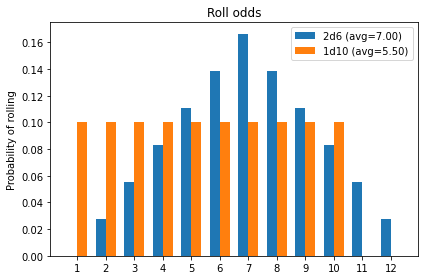

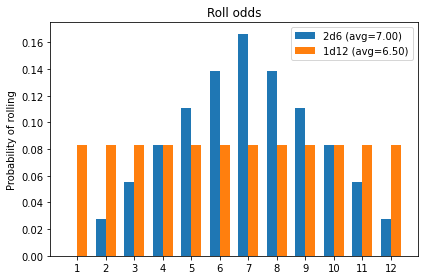

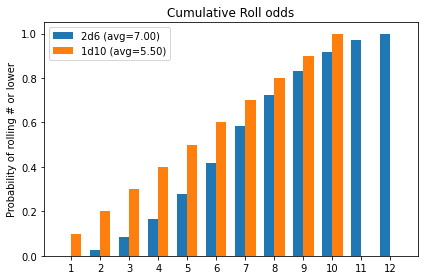

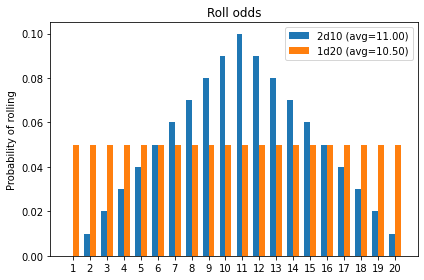

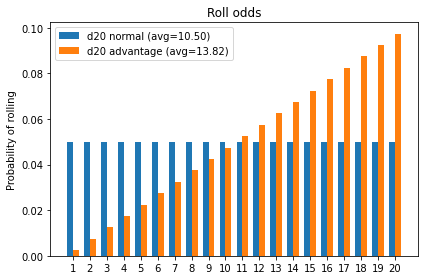

In [14]:
def compare_odds_dist(roll1_odds, roll2_odds, labels=('roll1', 'roll2'), cumulative=False):
    roll_values = set(roll1_odds.keys()) | set(roll2_odds.keys())
    r1_odds = [roll1_odds[k] if k in roll1_odds else 0 for k in roll_values]
    r2_odds = [roll2_odds[k] if k in roll2_odds else 0 for k in roll_values]
    if cumulative:
        r1_odds = [sum(r1_odds[:i+1]) if sum(r1_odds[:i])<0.9999 else 0 for i in range(len(r1_odds))]
        r2_odds = [sum(r2_odds[:i+1]) if sum(r2_odds[:i])<0.9999 else 0 for i in range(len(r2_odds))]

    x = np.arange(len(roll_values))  # the label locations
    width = 0.35  # the width of the bars

    r1_avg = sum([total * weight for total, weight in roll1_odds.items()])
    r2_avg = sum([total * weight for total, weight in roll2_odds.items()])

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, r1_odds, width, label=labels[0]+f" (avg={r1_avg:3.2f})")
    rects2 = ax.bar(x + width/2, r2_odds, width, label=labels[1]+f" (avg={r2_avg:3.2f})")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Probability of rolling')
    ax.set_title('Roll odds')
    if cumulative:
        ax.set_ylabel('Probability of rolling # or lower')
        ax.set_title('Cumulative Roll odds')
    ax.set_xticks(x)
    ax.set_xticklabels(roll_values)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:0.3f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    #autolabel(rects1)
    #autolabel(rects2)


    
    fig.tight_layout()
    plt.show()
    
compare_odds_dist(
    total_odds(6, n=2, adder=0, adv='normal', reroll_nums=()),
    total_odds(10, n=1, adder=0, adv='normal', reroll_nums=[]),
    labels=['2d6', '1d10']
)
compare_odds_dist(
    total_odds(6, n=2, adder=0, adv='normal', reroll_nums=()),
    total_odds(12, n=1, adder=0, adv='normal', reroll_nums=[]),
    labels=['2d6', '1d12']
)
compare_odds_dist(
    total_odds(6, n=2, adder=0, adv='normal', reroll_nums=[]),
    total_odds(10, n=1, adder=0, adv='normal', reroll_nums=[]),
    labels=['2d6', '1d10'],
    cumulative=True
)
compare_odds_dist(
    total_odds(10, n=2, adder=0, adv='normal', reroll_nums=[]),
    total_odds(20, n=1, adder=0, adv='normal', reroll_nums=[]),
    labels=['2d10', '1d20']
)
compare_odds_dist(
    total_odds(20, n=1, adder=0, adv='normal', reroll_nums=[]),
    total_odds(20, n=1, adder=0, adv='advantage', reroll_nums=[]),
    labels=['d20 normal', 'd20 advantage']
)

# Chance to hit grid

In [15]:
def chance_to_hit_grid(abil_mods=[0,1,2,3,4,5,6,7,8], 
                       lvls=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
                       adv='nor', crit_hit_nums=(20,), crit_fail_nums=(1,), print_table=True):
    '''Creates a grid of chance to hit at different PC levels and core ability (e.g. Strength) modifiers
    The proficiency bonus is calculated based on the PC level.  The chance to hit is based on the 
    AC of the monsters that are likely to be encountered at that PC level
    
    This is calculated by looking at every possible roll total and seeing if it hits against every possible
    AC, and then adjusting using the weighted odds of each roll total and the weighted odds of each AC.
    '''
    df = pd.DataFrame(np.zeros((len(lvls),len(abil_mods))),
                       columns=abil_mods,
                       index=lvls)
    df = df.rename_axis("Ability modifier", axis="columns")
    df = df.rename_axis("PC Level", axis="index")
    pd.set_option("display.float_format", lambda f: f"{f:0.0%}")
    col_width = 6
    num_width = 4
    prec = 0
    if(print_table):
        # print x axis label
        print(f"{'': >{col_width}}{'PC level'}")
        # print column header
        print(f"{'mod': <{col_width}}", end='')
        for lvl in lvls:
            print(f"{lvl: ^{col_width}}", end='')
        print('')
    # print one row for each attack modifier
    for a_mod in abil_mods:
        if(print_table):
            # row label first
            print(f"{a_mod: <{col_width}}", end='')
        for lvl in lvls:
            cth = chance_to_hit(abil_mod=a_mod, pc_lvl=lvl, adv=adv, crit_hit_nums=crit_hit_nums, crit_fail_nums=crit_fail_nums)
            df.loc[lvl,a_mod] = cth
            if(print_table):
                print(f"{cth:{num_width}.{prec}%}{'': <{col_width-num_width}}", end='')
        if(print_table):
            print('')
    return df

norm = chance_to_hit_grid(adv='nor', print_table=True)
norm.to_csv('chance_to_hit_norm.csv')
adv = chance_to_hit_grid(adv='adv', print_table=False)
adv.to_csv('chance_to_hit_adv.csv')
disadv = chance_to_hit_grid(adv='dis', print_table=False)
disadv.to_csv('chance_to_hit_disadv.csv')
norm

      PC level
mod     1     2     3     4     5     6     7     8     9     10    11    12    13    14    15    16    17    18    19    20  
0      55%   53%   52%   51%   49%   48%   46%   44%   43%   41%   40%   38%   37%   36%   34%   33%   31%   29%   28%   27%  
1      55%   53%   52%   51%   54%   53%   51%   49%   53%   51%   50%   48%   52%   51%   49%   48%   51%   49%   48%   46%  
2      60%   58%   57%   56%   59%   58%   56%   54%   58%   56%   55%   53%   57%   56%   54%   52%   56%   54%   53%   51%  
3      65%   63%   62%   60%   64%   63%   61%   59%   63%   61%   60%   58%   62%   61%   59%   57%   61%   59%   58%   56%  
4      69%   68%   67%   65%   69%   68%   66%   64%   68%   66%   65%   63%   67%   66%   64%   62%   66%   64%   62%   61%  
5      74%   73%   72%   70%   74%   73%   71%   69%   72%   71%   70%   68%   72%   71%   69%   67%   70%   69%   67%   66%  
6      79%   78%   77%   75%   79%   77%   76%   74%   77%   76%   75%   73%   77%   76%   73%  

Ability modifier,0,1,2,3,4,5,6,7,8
PC Level,,,,,,,,,
1,55%,55%,60%,65%,69%,74%,79%,84%,89%
2,53%,53%,58%,63%,68%,73%,78%,83%,87%
3,52%,52%,57%,62%,67%,72%,77%,82%,86%
4,51%,51%,56%,60%,65%,70%,75%,80%,85%
5,49%,54%,59%,64%,69%,74%,79%,83%,88%
6,48%,53%,58%,63%,68%,73%,77%,82%,87%
7,46%,51%,56%,61%,66%,71%,76%,81%,86%
8,44%,49%,54%,59%,64%,69%,74%,79%,84%
9,43%,53%,58%,63%,68%,72%,77%,82%,86%


# Attack Comparison

In [16]:
def compare_attacks(attacks,
                    baseline = None,
                    advantages=None, 
                    pc_lvls=[5]):
    '''
    compare_attacks
    Prints out chance to hit, avg damage on hit and probable damage for two attacks to compare them.
    If 'baseline' is specified, then it gives the difference from the baseline, not the absolute value.
    Will also repeat the comparison for adv and pc_lvls specified.
    It also returns a dataframe of the results
    
    Arguments
    attacks: a list of dictionaries which specify different attacks to be compared
                REQUIRED keys:
                    'dmg_die': for example '6' means a d6 damage die is used
                    'dmg_n': the number of 'dmg_die' that are rolled for attack
                    ONE OF THE FOLLOWING TWO COMBINATIONS
                        1) 'mod' and 'dmg_adder' (in this case, pc_level and proficiency is ignored and assumed included in 'mod')
                        or
                        2) 'abil_mod' and 'other_atk_mod' and 'other_dmg_mod' and (optionally) 'proficient'.  In this case, the pc
                            level will be used to look up a proficiency bonus which is added to abil_mod for attack rolls
                            (proficiency with the weapon will be assumed unless 'proficient' is specified as False).  'other_atk_mod'
                            can be used, for example, for +1 weapons (which should also use an 'other_dmg_mod' of +1 as well)
                OPTIONAL keys:
                    'dmg_reroll_nums': a list of numbers that will be re-rolled (once) on the damage die.  Great Weapon Fighter, for example,
                        would specify '[1,2]' to denote that ones and twos are re-rolled once on damage die rolls.  Default=[]
                    'crit_hit_nums': a list of numbers that count as critical hits. default=[20]
                    'crit_miss_nums': a list of numbers that count as critical misses.  default=(1)
                    'label': If specified, this will be used to describe the attack in the output table.
                    'adv_mix': a dictionary specifying the average mix of attacks that have advantage, disadvantage or normal rolls.  It is
                        given as a dictionary with keys 'nor', 'adv', 'dis' and values as the % of attacks made with that kind of roll.  The
                        values should add to 1.  Example: {'adv':.2, 'nor': .7, 'dis':.1}.  Default={'adv':0, 'nor':1, 'dis':0} OR the advantage
                        specified by the 'advantages' option to compare_attacks.  Note that if 'adv_mix' is specified in any of the attacks,
                        then 'advantages' cannot be specified for 'compare_attacks' -- if both are specified, an error is raised.
                    'to_hit_adder_dice' = any die rolled and added to your attack roll (for example, an inspiration d6).
                              default=None
                    'to_hit_adder_n' = number of additional to hit die to roll
                    'to_hit_adder_dice_percentage' = the percentage of time a to_hit_adder_dice is added (how often do you get inspiration?)
                    'dmg_adder_dice' = any die rolled and added to your damage (for example, an rogue's sneak attack bonus d6).
                              default=None
                    'dmg_adder_n' = number of dmg_adder die to roll
                    'dmg_adder_dice_percentage' = the percentage of time a dmg_adder_dice is added (how often do you get sneak attack?)

    baseline: a dictionary with the same key value rules as 'attacks' above
    advantages: list of 'nor', 'adv', or 'dis' which will result in the comparisons being repeated for each of the advantage conditions.
                if not specified, then all attacks will be assumed to be normal, or to use the advantage mix specified in the
                attack dictionary.
                If advantages is specified AND an advantage mix is specified in an attack dictionary, an error will be raised.
    pc_lvls: list of pc levels which will result in the comparisons being repeated for each PC level
    '''
    includes_adv_mix = False
    for atk in attacks:
        if 'adv_mix' in atk:
            includes_adv_mix = True
    if advantages:
        if includes_adv_mix:
            raise ValueError("You cannot specify 'advantages' when one of your attacks includes 'adv_mix'")
    else:
        if includes_adv_mix:
            advantages = ['custom']
        else:
            advantages = ['nor']
    column_names = ['Chance to hit', 'Avg damage on hit', 'Probable Damage']
    if baseline:
        df = pd.DataFrame(np.zeros(((len(attacks)+1)*len(list(product(pc_lvls, advantages))),3)), columns=column_names)
    else:
        df = pd.DataFrame(np.zeros((len(attacks)*len(list(product(pc_lvls, advantages))),3)), columns=column_names)
    #df = df.rename_axis("Measurement", axis="columns")
    pd.set_option("display.float_format", lambda f_val: f"{f_val:0<4.4f}")

    #ord_ending = {num: ending for num, ending in enumerate(['st','nd','rd']+(['th']*18))}
    #table_title = f"({pc_lvl}{ord_ending[pc_lvl-1]} lvl, {adv})"
    col_one_width = 60
    col_width = 20
    num_width = 8
    prec = 1
    atk_descriptions = []
    chance_to_hits = []
    avg_dmg_on_hits = []
    probable_dmgs = []
    if baseline:
        atk_descriptions.append('BASELINE: ' + get_attack_description(baseline))
    for atk in attacks:
            atk_descriptions.append(get_attack_description(atk))
    for pc_lvl, adv in product(pc_lvls, advantages):
        if baseline:
            baseline_cth, baseline_adoh, baseline_probd = calc_stats(baseline, pc_lvl, adv)
            chance_to_hits.append(baseline_cth)
            avg_dmg_on_hits.append(baseline_adoh)
            probable_dmgs.append(baseline_probd)
        for atk in attacks:
            cth, adoh, probd = calc_stats(atk, pc_lvl, adv)
            if baseline:
                chance_to_hits.append(cth - baseline_cth)
                avg_dmg_on_hits.append(adoh - baseline_adoh)
                probable_dmgs.append(probd - baseline_probd)
            else:
                chance_to_hits.append(cth)
                avg_dmg_on_hits.append(adoh)
                probable_dmgs.append(probd)
    
    #df.index = atk_descriptions
    #df = df.rename_axis("Attack", axis="index")
    df.index = pd.MultiIndex.from_product([pc_lvls, advantages, atk_descriptions],
                           names=['pc_level', 'advantage', 'attack'])
    df[column_names[0]] = chance_to_hits
    df[column_names[1]] = avg_dmg_on_hits
    df[column_names[2]] = probable_dmgs
    return df

def calc_stats(attack, pc_lvl, adv):
    '''return a tuple of (chance_to_hit, dmg_on_hit, probably_dmg)'''    
    atk_vals = parse_attack(attack, pc_lvl, adv)
    cth = chance_to_hit(mod=atk_vals['mod'], 
                        pc_lvl=pc_lvl, 
                        adv=atk_vals['adv'],
                        crit_hit_nums=atk_vals['crit_hit_nums'], 
                        crit_fail_nums=atk_vals['crit_fail_nums'],
                        to_hit_adder_dice=atk_vals['to_hit_adder_dice'],
                        to_hit_adder_n=atk_vals['to_hit_adder_n'],
                        to_hit_adder_dice_percentage=atk_vals['to_hit_adder_dice_percentage']
                       )
    crit_hit_chance = critical_odds(20, adv=atk_vals['adv'], crit_nums=atk_vals['crit_hit_nums'])
    noncrit_hit_chance = 1 - crit_hit_chance
    non_crit_adoh = avg_dmg(dmg_die=attack['dmg_die'],
                   dmg_n=attack['dmg_n'],
                   dmg_adder=atk_vals['dmg_adder'], 
                   dmg_reroll_nums=atk_vals['dmg_reroll_nums'],
                   dmg_adder_dice=atk_vals['dmg_adder_dice'],
                   dmg_adder_n=atk_vals['dmg_adder_n'],
                   dmg_adder_dice_percentage=atk_vals['dmg_adder_dice_percentage'],
                   is_crit=False
                  )
    crit_adoh = avg_dmg(dmg_die=attack['dmg_die'],
                   dmg_n=attack['dmg_n'],
                   dmg_adder=atk_vals['dmg_adder'], 
                   dmg_reroll_nums=atk_vals['dmg_reroll_nums'],
                   dmg_adder_dice=atk_vals['dmg_adder_dice'],
                   dmg_adder_n=atk_vals['dmg_adder_n'],
                   dmg_adder_dice_percentage=atk_vals['dmg_adder_dice_percentage'],
                   is_crit=True
                  )
    adoh = (crit_hit_chance * crit_adoh) + (noncrit_hit_chance * non_crit_adoh)
    pd = probable_damage(mod=atk_vals['mod'],
                         pc_lvl=pc_lvl,
                         adv=atk_vals['adv'],
                         crit_hit_nums=atk_vals['crit_hit_nums'],
                         crit_fail_nums=atk_vals['crit_fail_nums'],
                         dmg_die=attack['dmg_die'],
                         dmg_n=attack['dmg_n'], 
                         dmg_adder=atk_vals['dmg_adder'], 
                         dmg_reroll_nums=atk_vals['dmg_reroll_nums'],
                         to_hit_adder_dice=atk_vals['to_hit_adder_dice'],
                         to_hit_adder_n=atk_vals['to_hit_adder_n'],
                         to_hit_adder_dice_percentage=atk_vals['to_hit_adder_dice_percentage'],
                         dmg_adder_dice=atk_vals['dmg_adder_dice'],
                         dmg_adder_n=atk_vals['dmg_adder_n'],
                         dmg_adder_dice_percentage=atk_vals['dmg_adder_dice_percentage'],
                        )
    return (cth, adoh, pd)
    

def get_attack_description(atk):
    if('label' in atk):
#        atk_description = f"{table_title} {atk['label']}"
        atk_description = f"{atk['label']}"
    else:
#        atk_description = f"{table_title} +{mod} to hit, {atk['dmg_n']}d{atk['dmg_die']}+{dmg_adder}, reroll {dmg_reroll_nums}, crit_hits {crit_hit_nums}, crit_fails {crit_fail_nums}"
        atk_vals = parse_attack(atk, [1], ['nor'])
        atk_description = f"""+{atk_vals['mod']} to hit, {atk['dmg_n']}d{atk['dmg_die']}+{atk_vals['dmg_adder']}, 
        reroll {atk_vals['dmg_reroll_nums']}, crit_hits {atk_vals['crit_hit_nums']}, crit_fails {atk_vals['crit_fail_nums']}"""
    return atk_description

def parse_attack(atk, pc_lvl, adv):
    if 'abil_mod' in atk:
        if 'proficient' in atk:
            mod = total_atk_mod(pc_lvl=pc_lvl, abil_mod=atk['abil_mod'], other_atk_mod=atk['other_atk_mod'], proficient=atk['proficient'])
        else:
            mod = total_atk_mod(pc_lvl=pc_lvl, abil_mod=atk['abil_mod'], other_atk_mod=atk['other_atk_mod'])
        dmg_adder = total_dmg_mod(abil_mod=atk['abil_mod'], other_dmg_mod=atk['other_dmg_mod'])
    else:
        mod = atk['mod']
        dmg_adder = atk['dmg_adder']
        
    if 'adv_mix' in atk:
        atk_adv = atk['adv_mix']
    else:
        if not adv.lower().startswith('cus'): #if 'custom'
            atk_adv = adv
        else:
            # this is the case when one attack has adv_mix, but not all do.  For those
            # that don't, specify normal roll (not advantage)
            atk_adv = 'nor'

    #if 'dmg_reroll_nums' in atk:
    #    dmg_reroll_nums = atk['dmg_reroll_nums']
    #else:
    #    dmg_reroll_nums = []
    #    
    #if 'crit_hit_nums' in atk:
    #    crit_hit_nums = atk['crit_hit_nums']
    #else:
    #    crit_hit_nums = (20,)
    #    
    #if 'crit_fail_nums' in atk:
    #    crit_fail_nums = atk['crit_fail_nums']
    #else:
    #    crit_fail_nums = [1,]


    dmg_reroll_nums = () if 'dmg_reroll_nums' not in atk else atk['dmg_reroll_nums']
    crit_hit_nums = (20,) if 'crit_hit_nums' not in atk else atk['crit_hit_nums']
    crit_fail_nums = (1,) if 'crit_fail_nums' not in atk else atk['crit_fail_nums']
    to_hit_adder_dice = None if 'to_hit_adder_dice' not in atk else atk['to_hit_adder_dice']
    to_hit_adder_n = 1 if 'to_hit_adder_n' not in atk else atk['to_hit_adder_n']
    to_hit_adder_dice_percentage = 1 if 'to_hit_adder_dice_percentage' not in atk else atk['to_hit_adder_dice_percentage']
    dmg_adder_dice = None if 'dmg_adder_dice' not in atk else atk['dmg_adder_dice']
    dmg_adder_n = 1 if 'dmg_adder_n' not in atk else atk['dmg_adder_n']
    dmg_adder_dice_percentage = 1 if 'dmg_adder_dice_percentage' not in atk else atk['dmg_adder_dice_percentage']
        
    return_dict = {'mod':mod, 'dmg_adder':dmg_adder, 'dmg_reroll_nums':dmg_reroll_nums, 'crit_hit_nums':crit_hit_nums, 
                   'crit_fail_nums':crit_fail_nums, 'adv':atk_adv, 'to_hit_adder_dice':to_hit_adder_dice,
                   'to_hit_adder_n':to_hit_adder_n, 'to_hit_adder_dice_percentage':to_hit_adder_dice_percentage,
                   'dmg_adder_dice':dmg_adder_dice, 'dmg_adder_n':dmg_adder_n, 
                   'dmg_adder_dice_percentage':dmg_adder_dice_percentage
                  }
    return return_dict

In [17]:
print('should I take an ability score improvement or the GWM feat')
compare_attacks([
                {'abil_mod':4, 'other_atk_mod':-5, 'other_dmg_mod':10, 'dmg_die':6,'dmg_n':2, 'dmg_reroll_nums':(1,2), 'label':'STR:4, GWF, GWM, maul'},
                {'abil_mod':4, 'other_atk_mod':1-5, 'other_dmg_mod':1+10, 'dmg_die':6,'dmg_n':2, 'dmg_reroll_nums':(1,2), 'label':'STR:4, GWF, GWM, +1 maul'},
                {'abil_mod':5, 'other_atk_mod':0, 'other_dmg_mod':0, 'dmg_die':6,'dmg_n':2, 'dmg_reroll_nums':(1,2), 'label':'STR:5, GWF, maul'},
                {'abil_mod':5, 'other_atk_mod':1, 'other_dmg_mod':1, 'dmg_die':6,'dmg_n':2, 'dmg_reroll_nums':(1,2), 'label':'STR:5, GWF, +1 maul'},
                {'abil_mod':5, 'other_atk_mod':1, 'other_dmg_mod':1, 'dmg_die':10,'dmg_n':1, 'dmg_reroll_nums':(1,2), 'label':'STR:5, GWF, +1 longsword'},
                {'abil_mod':5, 'other_atk_mod':1, 'other_dmg_mod':1, 'dmg_die':6,'dmg_n':2, 'dmg_reroll_nums':(1,2), 'label':'STR:5, GWF, +1 greatsword'},
                {'abil_mod':4, 'other_atk_mod':0, 'other_dmg_mod':0, 'dmg_die':6,'dmg_n':1, 'dmg_reroll_nums':(), 'label':'STR:4, javelin'},
                ],
                pc_lvls=[6], advantages=['adv', 'nor', 'dis'])


should I take an ability score improvement or the GWM feat


Chance to hit  \
pc_level advantage attack                                     
6        adv       STR:4, GWF, GWM, maul             0.6565   
                   STR:4, GWF, GWM, +1 maul          0.7113   
                   STR:5, GWF, maul                  0.9106   
                   STR:5, GWF, +1 maul               0.9357   
                   STR:5, GWF, +1 longsword          0.9357   
                   STR:5, GWF, +1 greatsword         0.9357   
                   STR:4, javelin                    0.8807   
         nor       STR:4, GWF, GWM, maul             0.4269   
                   STR:4, GWF, GWM, +1 maul          0.4769   
                   STR:5, GWF, maul                  0.7250   
                   STR:5, GWF, +1 maul               0.7739   
                   STR:5, GWF, +1 longsword          0.7739   
                   STR:5, GWF, +1 greatsword         0.7739   
                   STR:4, javelin                    0.6759   
         dis       STR:4, GWF, GWM, maul             0.1973   
                   STR:4, GWF, GWM, +1 maul          0.2425   
                   STR:5, GWF, maul                  0.5395   
                   STR:5, GWF, +1 maul               0.6122   
                   STR:5, GWF, +1 longsword          0.6122   
                   STR:5, GWF, +1 greatsword         0.6122   
                   STR:4, javelin                    0.4711   

                                              Avg damage on hit  \
pc_level advantage attack                                         
6        adv       STR:4, GWF, GWM, maul                22.9019   
                   STR:4, GWF, GWM, +1 maul             23.9019   
                   STR:5, GWF, maul                     13.9019   
                   STR:5, GWF, +1 maul                  14.9019   
                   STR:5, GWF, +1 longsword             12.9142   
                   STR:5, GWF, +1 greatsword            14.9019   
                   STR:4, javelin                        7.8412   
         nor       STR:4, GWF, GWM, maul                22.5167   
                   STR:4, GWF, GWM, +1 maul             23.5167   
                   STR:5, GWF, maul                     13.5167   
                   STR:5, GWF, +1 maul                  14.5167   
                   STR:5, GWF, +1 longsword             12.6150   
                   STR:5, GWF, +1 greatsword            14.5167   
                   STR:4, javelin                        7.6750   
         dis       STR:4, GWF, GWM, maul                22.1314   
                   STR:4, GWF, GWM, +1 maul             23.1314   
                   STR:5, GWF, maul                     13.1314   
                   STR:5, GWF, +1 maul                  14.1314   
                   STR:5, GWF, +1 longsword             12.3158   
                   STR:5, GWF, +1 greatsword            14.1314   
                   STR:4, javelin                        7.5087   

                                              Probable Damage  
pc_level advantage attack                                      
6        adv       STR:4, GWF, GWM, maul              15.0350  
                   STR:4, GWF, GWM, +1 maul           17.0015  
                   STR:5, GWF, maul                   12.6594  
                   STR:5, GWF, +1 maul                13.9434  
                   STR:5, GWF, +1 longsword           12.0835  
                   STR:5, GWF, +1 greatsword          13.9434  
                   STR:4, javelin                      6.9056  
         nor       STR:4, GWF, GWM, maul               9.6122  
                   STR:4, GWF, GWM, +1 maul           11.2150  
                   STR:5, GWF, maul                    9.8002  
                   STR:5, GWF, +1 maul                11.2350  
                   STR:5, GWF, +1 longsword            9.7632  
                   STR:5, GWF, +1 greatsword          11.2350  
                   STR:4, javelin                      5.1874  
         dis       STR:4, GWF,

In [18]:
print("I'm under water without a swim speed, should I attack with a +1 greatsword at disadvantage or with a javelin at normal?")
compare_attacks([
                {'abil_mod':4, 'other_atk_mod':1, 'other_dmg_mod':1, 'dmg_die':6,'dmg_n':2, 'dmg_reroll_nums':(1,2), 'label':'+1 magic greatsword with GWF rerolls'},
                {'abil_mod':4, 'other_atk_mod':0, 'other_dmg_mod':0, 'dmg_die':6,'dmg_n':1, 'dmg_reroll_nums':(), 'label':'javelin at normal no rerolls'},
                ],
                pc_lvls=[6,], advantages=['adv', 'nor', 'dis'])

I'm under water without a swim speed, should I attack with a +1 greatsword at disadvantage or with a javelin at normal?


Chance to hit  \
pc_level advantage attack                                                
6        adv       +1 magic greatsword with GWF rerolls         0.9106   
                   javelin at normal no rerolls                 0.8807   
         nor       +1 magic greatsword with GWF rerolls         0.7250   
                   javelin at normal no rerolls                 0.6759   
         dis       +1 magic greatsword with GWF rerolls         0.5395   
                   javelin at normal no rerolls                 0.4711   

                                                         Avg damage on hit  \
pc_level advantage attack                                                    
6        adv       +1 magic greatsword with GWF rerolls            13.9019   
                   javelin at normal no rerolls                     7.8412   
         nor       +1 magic greatsword with GWF rerolls            13.5167   
                   javelin at normal no rerolls                     7.6750   
         dis       +1 magic greatsword with GWF rerolls            13.1314   
                   javelin at normal no rerolls                     7.5087   

                                                         Probable Damage  
pc_level advantage attack                                                 
6        adv       +1 magic greatsword with GWF rerolls          12.6594  
                   javelin at normal no rerolls                   6.9056  
         nor       +1 magic greatsword with GWF rerolls           9.8002  
                   javelin at normal no rerolls                   5.1874  
         dis       +1 magic greatsword with GWF rerolls           7.0840  
                   javelin at normal no rerolls                   3.5373

# Attack comparison relative to a baseline for different options
This will be a table that shows the increase in chance-to-hit, avg dmg on hit, and probable dmg versus a given baseline.

In [19]:
attacks = [
    {'abil_mod':4, 'other_atk_mod':0, 'other_dmg_mod':0, 'dmg_die':6,'dmg_n':2, 'dmg_reroll_nums':(), 'crit_hit_nums':(20,), 'label':'4 STR, 2d6 dmg weapon'},
    {'abil_mod':5, 'other_atk_mod':0, 'other_dmg_mod':0, 'dmg_die':6,'dmg_n':2, 'dmg_reroll_nums':(), 'crit_hit_nums':(20,), 'label':'5 STR, 2d6 dmg weapon'},
    {'abil_mod':4, 'other_atk_mod':1, 'other_dmg_mod':1, 'dmg_die':6,'dmg_n':2, 'dmg_reroll_nums':(), 'crit_hit_nums':(20,), 'label':'+1 Weapon'},
    {'abil_mod':4, 'other_atk_mod':0, 'other_dmg_mod':0, 'dmg_die':6,'dmg_n':2, 'dmg_reroll_nums':(1,2), 'crit_hit_nums':(20,), 'label':'GWF (reroll 1s and 2s)'},
    {'abil_mod':4, 'other_atk_mod':-5, 'other_dmg_mod':10, 'dmg_die':6,'dmg_n':2, 'dmg_reroll_nums':(), 'crit_hit_nums':(20,), 'label':'GWM (-5 to hit, +10 dmg)'},
    {'abil_mod':4, 'other_atk_mod':0, 'other_dmg_mod':0, 'dmg_die':6,'dmg_n':2, 'dmg_reroll_nums':(), 'crit_hit_nums':(19,20), 'label':'Expanded Crits to 19 & 20'},
    {'abil_mod':4, 'other_atk_mod':0, 'other_dmg_mod':0, 'dmg_die':6,'dmg_n':2, 'dmg_reroll_nums':(), 'dmg_adder_dice':6, 'dmg_adder_n':2, 
     'dmg_adder_dice_percentage':.2, 'crit_hit_nums':(20,), 'label':'2d6 sneak attack on 20% of hits'},
]
compare_results = compare_attacks(attacks, baseline=attacks[0], pc_lvls=[6,], advantages=['advantage', 'normal', 'disadvantage'])
compare_results.to_csv('comparisons_advnordis.csv')
compare_results

Chance to hit  \
pc_level advantage    attack                                           
6        advantage    BASELINE: 4 STR, 2d6 dmg weapon         0.8807   
                      4 STR, 2d6 dmg weapon                   0.0000   
                      5 STR, 2d6 dmg weapon                   0.0300   
                      +1 Weapon                               0.0300   
                      GWF (reroll 1s and 2s)                  0.0000   
                      GWM (-5 to hit, +10 dmg)               -0.2242   
                      Expanded Crits to 19 & 20               0.0000   
                      2d6 sneak attack on 20% of hits         0.0000   
         normal       BASELINE: 4 STR, 2d6 dmg weapon         0.6759   
                      4 STR, 2d6 dmg weapon                   0.0000   
                      5 STR, 2d6 dmg weapon                   0.0492   
                      +1 Weapon                               0.0492   
                      GWF (reroll 1s and 2s)                  0.0000   
                      GWM (-5 to hit, +10 dmg)               -0.2490   
                      Expanded Crits to 19 & 20               0.0000   
                      2d6 sneak attack on 20% of hits         0.0000   
         disadvantage BASELINE: 4 STR, 2d6 dmg weapon         0.4711   
                      4 STR, 2d6 dmg weapon                   0.0000   
                      5 STR, 2d6 dmg weapon                   0.0684   
                      +1 Weapon                               0.0684   
                      GWF (reroll 1s and 2s)                  0.0000   
                      GWM (-5 to hit, +10 dmg)               -0.2738   
                      Expanded Crits to 19 & 20               0.0000   
                      2d6 sneak attack on 20% of hits         0.0000   

                                                       Avg damage on hit  \
pc_level advantage    attack                                               
6        advantage    BASELINE: 4 STR, 2d6 dmg weapon            11.6825   
                      4 STR, 2d6 dmg weapon                       0.0000   
                      5 STR, 2d6 dmg weapon                       1.0000   
                      +1 Weapon                                   1.0000   
                      GWF (reroll 1s and 2s)                      1.2194   
                      GWM (-5 to hit, +10 dmg)                   10.0000   
                      Expanded Crits to 19 & 20                   0.6475   
                      2d6 sneak attack on 20% of hits             1.4000   
         normal       BASELINE: 4 STR, 2d6 dmg weapon            11.3500   
                      4 STR, 2d6 dmg weapon                       0.0000   
                      5 STR, 2d6 dmg weapon                       1.0000   
                      +1 Weapon                                   1.0000   
                      GWF (reroll 1s and 2s)                      1.1667   
                      GWM (-5 to hit, +10 dmg)                   10.0000   
                      Expanded Crits to 19 & 20                   0.3500   
                      2d6 sneak attack on 20% of hits             1.4000   
         disadvantage BASELINE: 4 STR, 2d6 dmg weapon            11.0175   
                      4 STR, 2d6 dmg weapon                       0.0000   
                      5 STR, 2d6 dmg weapon                       1.0000   
                      +1 Weapon                                   1.0000   
                      GWF (reroll 1s and 2s)                      1.1139   
                      GWM (-5 to hit, +10 dmg)                   10.0000   
                      Expanded Crits to 19 & 20                   0.0525   
                      2d6 sneak attack on 20% of hits             1.4000   

                                                       Probable Damage  
pc_level advantage    attack                                            
6        advantage    BASELINE: 4 STR, 2d6 dmg weapon      

# Attack Comparison at an assumed Advantage Mix -- two methods:
## 1) use same advantage mix for all by using 'compare_attacks_at_advantage_mix'
## 2) Use individual advantage mixes for each attack by using 'compare_attacks' with 'adv_mix' specified for attacks


### Here is the 1) method:

In [20]:
def compare_attacks_at_advantage_mix(attacks, baseline=attacks[0], pc_lvls=[5], adv_mix={'adv':.10, 'nor':.85, 'dis':.05}):
    '''return a dataframe which gives attack statistics assuming an advantage mix (i.e. what percent 
    of the time do you attack with advantage).
    
    Arguments
    compare_df:  This is a dataframe which is the output of "compare_attacks" assuming that all three
    advantages were specified in the "compare_attacks" arguments.  Ths DF will have "advantage" as the
    second level of the MultiIndex.
    
    adv_mix: a dictionary with the keys of ['adv', 'nor', 'dis'] and values representing the mix of
    attacks which will be made with that advantage (these three values should add up to 1).'''
    compare_df = compare_attacks(attacks, baseline, pc_lvls=pc_lvls, advantages=['adv', 'nor', 'dis'])
    idx = pd.IndexSlice
    advantage = compare_df.loc[idx[:,'adv',:],:].reset_index().set_index(['pc_level', 'attack']).drop(labels='advantage', axis=1)
    normal = compare_df.loc[idx[:,'nor',:],:].reset_index().set_index(['pc_level', 'attack']).drop(labels='advantage', axis=1)
    disadvantage = compare_df.loc[idx[:,'dis',:],:].reset_index().set_index(['pc_level', 'attack']).drop(labels='advantage', axis=1)

    average_df = (advantage * adv_mix['adv']) + (normal * adv_mix['nor']) + (disadvantage * adv_mix['dis'])
    return average_df

In [21]:

print('Statistics of attacks assuming advantage 20%, normal 75%, disadvantage 5%')
compare_207505 = compare_attacks_at_advantage_mix(attacks, pc_lvls=[6], adv_mix={'adv':.20, 'nor':.75, 'dis':.05})
compare_207505.to_csv('compare_207505.csv')
compare_207505

Statistics of attacks assuming advantage 20%, normal 75%, disadvantage 5%


Chance to hit  Avg damage on hit  \
pc_level attack                                                              
6        BASELINE: 4 STR, 2d6 dmg weapon         0.7066            11.3999   
         4 STR, 2d6 dmg weapon                   0.0000             0.0000   
         5 STR, 2d6 dmg weapon                   0.0463             1.0000   
         +1 Weapon                               0.0463             1.0000   
         GWF (reroll 1s and 2s)                  0.0000             1.1746   
         GWM (-5 to hit, +10 dmg)               -0.2453            10.0000   
         Expanded Crits to 19 & 20               0.0000             0.3946   
         2d6 sneak attack on 20% of hits         0.0000             1.4000   

                                          Probable Damage  
pc_level attack                                            
6        BASELINE: 4 STR, 2d6 dmg weapon           8.0706  
         4 STR, 2d6 dmg weapon                     0.0000  
         5 STR, 2d6 dmg weapon                     1.2791  
         +1 Weapon                                 1.2791  
         GWF (reroll 1s and 2s)                    0.8324  
         GWM (-5 to hit, +10 dmg)                  1.8193  
         Expanded Crits to 19 & 20                 0.2927  
         2d6 sneak attack on 20% of hits           0.9892

### Here is the 2) method

In [23]:
attacks = [
    {'abil_mod':4, 'other_atk_mod':0, 'other_dmg_mod':0, 'dmg_die':6,'dmg_n':2, 'dmg_reroll_nums':[], 
         'crit_hit_nums':[20], 'adv_mix':{'adv':.1, 'nor':.85, 'dis':.05}, 'label':'(Current) 4 STR, 2d6 - adv:10/85/05'},
    
    {'abil_mod':4, 'other_atk_mod':0, 'other_dmg_mod':0, 'dmg_die':6,'dmg_n':2, 'dmg_reroll_nums':[], 
         'crit_hit_nums':[20], 'adv_mix':{'adv':.3, 'nor':.65, 'dis':.05}, 'label':'Feature which increases Advantage: 4 STR, 2d6 - adv:30/65/05'},
    
    {'abil_mod':5, 'other_atk_mod':0, 'other_dmg_mod':0, 'dmg_die':6,'dmg_n':2, 'dmg_reroll_nums':[], 
         'crit_hit_nums':[20], 'adv_mix':{'adv':.1, 'nor':.85, 'dis':.05}, 'label':'Increase STR modifier: 5 STR, 2d6 - adv:10/85/05'},
    
    {'abil_mod':4, 'other_atk_mod':1, 'other_dmg_mod':1, 'dmg_die':6,'dmg_n':2, 'dmg_reroll_nums':[], 
         'crit_hit_nums':[20], 'adv_mix':{'adv':.1, 'nor':.85, 'dis':.05}, 'label':'Get a +1 Weapon- adv:10/85/05'},
    
    {'abil_mod':4, 'other_atk_mod':0, 'other_dmg_mod':0, 'dmg_die':6,'dmg_n':2, 'dmg_reroll_nums':[1,2], 
         'crit_hit_nums':[20], 'adv_mix':{'adv':.1, 'nor':.85, 'dis':.05}, 'label':'Take GWF (reroll 1s&2s)- adv:10/85/05'},
    
    {'abil_mod':4, 'other_atk_mod':-5, 'other_dmg_mod':10, 'dmg_die':6,'dmg_n':2, 'dmg_reroll_nums':[], 
         'crit_hit_nums':[20], 'adv_mix':{'adv':.1, 'nor':.85, 'dis':.05}, 'label':'Great Wpn Mster Feat (-5 to hit, +10 dmg)- adv:10/85/05'},
    
    {'abil_mod':4, 'other_atk_mod':0, 'other_dmg_mod':0, 'dmg_die':6,'dmg_n':2, 'dmg_reroll_nums':[], 
         'crit_hit_nums':(19,20), 'adv_mix':{'adv':.1, 'nor':.85, 'dis':.05}, 'label':'Improved Critical (19 & 20)- adv:10/85/05'},
    
    {'abil_mod':4, 'other_atk_mod':0, 'other_dmg_mod':0, 'dmg_die':6,'dmg_n':2, 'dmg_reroll_nums':[], 'dmg_adder_dice':6, 'dmg_adder_n':2, 
     'dmg_adder_dice_percentage':.2, 'crit_hit_nums':[20], 'adv_mix':{'adv':.1, 'nor':.85, 'dis':.05}, 'label':'2d6 sneak attack 20% of hits- adv:10/85/05'},

]
compare_df = compare_attacks(attacks, baseline=attacks[0], pc_lvls=[6])
compare_df.to_csv('compare_diffmixes.csv')
compare_df

Chance to hit  \
pc_level advantage attack                                                              
6        custom    BASELINE: (Current) 4 STR, 2d6 - adv:10/85/05              0.6861   
                   (Current) 4 STR, 2d6 - adv:10/85/05                        0.0000   
                   Feature which increases Advantage: 4 STR, 2d6 -...         0.0410   
                   Increase STR modifier: 5 STR, 2d6 - adv:10/85/05           0.0482   
                   Get a +1 Weapon- adv:10/85/05                              0.0482   
                   Take GWF (reroll 1s&2s)- adv:10/85/05                      0.0000   
                   Great Wpn Mster Feat (-5 to hit, +10 dmg)- adv:...        -0.2477   
                   Improved Critical (19 & 20)- adv:10/85/05                  0.0000   
                   2d6 sneak attack 20% of hits- adv:10/85/05                 0.0000   

                                                                       Avg damage on hit  \
pc_level advantage attack                                                                  
6        custom    BASELINE: (Current) 4 STR, 2d6 - adv:10/85/05                 11.3666   
                   (Current) 4 STR, 2d6 - adv:10/85/05                            0.0000   
                   Feature which increases Advantage: 4 STR, 2d6 -...             0.0665   
                   Increase STR modifier: 5 STR, 2d6 - adv:10/85/05               1.0000   
                   Get a +1 Weapon- adv:10/85/05                                  1.0000   
                   Take GWF (reroll 1s&2s)- adv:10/85/05                          1.1693   
                   Great Wpn Mster Feat (-5 to hit, +10 dmg)- adv:...            10.0000   
                   Improved Critical (19 & 20)- adv:10/85/05                      0.3649   
                   2d6 sneak attack 20% of hits- adv:10/85/05                     1.4000   

                                                                       Probable Damage  
pc_level advantage attack                                                               
6        custom    BASELINE: (Current) 4 STR, 2d6 - adv:10/85/05                7.7988  
                   (Current) 4 STR, 2d6 - adv:10/85/05                          0.0000  
                   Feature which increases Advantage: 4 STR, 2d6 -...           0.5139  
                   Increase STR modifier: 5 STR, 2d6 - adv:10/85/05             1.2823  
                   Get a +1 Weapon- adv:10/85/05                                1.2823  
                   Take GWF (reroll 1s&2s)- adv:10/85/05                        0.8023  
                   Great Wpn Mster Feat (-5 to hit, +10 dmg)- adv:...           1.5677  
                   Improved Critical (19 & 20)- adv:10/85/05                    0.2503  
                   2d6 sneak attack 20% of hits- adv:10/85/05                   0.9606

## Remi upgrade analysis
first, at just normal advantage

In [23]:
current = {'abil_mod':4, 'other_atk_mod':1, 'other_dmg_mod':1, 'dmg_die':6, 'dmg_n':2, 'dmg_reroll_nums':[1,2], 'label':'Current Remi'}
options = [
    {'abil_mod':5, 'other_atk_mod':1, 'other_dmg_mod':1, 'dmg_die':6,'dmg_n':2, 'dmg_reroll_nums':[1,2], 'label':'Increase STR to 20'},
    {'abil_mod':4, 'other_atk_mod':1-5, 'other_dmg_mod':1+10, 'dmg_die':6,'dmg_n':2, 'dmg_reroll_nums':[1,2], 'label':'Take GWM'},
]
remi_df = compare_attacks(options, baseline=current, pc_lvls=[8], advantages=['adv', 'nor', 'dis'])

remi_df

Chance to hit  Avg damage on hit  \
pc_level advantage attack                                                     
8        adv       BASELINE: Current Remi         0.8924            13.9019   
                   Increase STR to 20             0.0282             1.0000   
                   Take GWM                      -0.2156            10.0000   
         nor       BASELINE: Current Remi         0.6931            13.5167   
                   Increase STR to 20             0.0492             1.0000   
                   Take GWM                      -0.2491            10.0000   
         dis       BASELINE: Current Remi         0.4938            13.1314   
                   Increase STR to 20             0.0702             1.0000   
                   Take GWM                      -0.2826            10.0000   

                                           Probable Damage  
pc_level advantage attack                                   
8        adv       BASELINE: Current Remi          12.4061  
                   Increase STR to 20               1.3131  
                   Take GWM                         3.7696  
         nor       BASELINE: Current Remi           9.3681  
                   Increase STR to 20               1.4077  
                   Take GWM                         1.0727  
         dis       BASELINE: Current Remi           6.4837  
                   Increase STR to 20               1.4862  
                   Take GWM                        -1.5984

Now at 12% advantage, 83% normal and 5% disadvantage

In [24]:
adv_mix = {'adv':.15, 'nor':.80, 'dis':.05}
print(f'''Statistics of attacks assuming advantage {adv_mix['adv']}, normal {adv_mix['nor']}, disadvantage {adv_mix['dis']}''')
compare_attacks_at_advantage_mix(options, baseline=current, pc_lvls=[8], adv_mix=adv_mix)

Statistics of attacks assuming advantage 0.15, normal 0.8, disadvantage 0.05


Chance to hit  Avg damage on hit  \
pc_level attack                                                     
8        BASELINE: Current Remi         0.7130            13.5552   
         Increase STR to 20             0.0471             1.0000   
         Take GWM                      -0.2458            10.0000   

                                 Probable Damage  
pc_level attack                                   
8        BASELINE: Current Remi           9.6796  
         Increase STR to 20               1.3975  
         Take GWM                         1.3437

Now at 20% advantage, 75
% normal and 5% disadvantage

In [25]:
adv_mix = {'adv':.20, 'nor':.75, 'dis':.05}
print(f'''Statistics of attacks assuming advantage {adv_mix['adv']}, normal {adv_mix['nor']}, disadvantage {adv_mix['dis']}''')
compare_attacks_at_advantage_mix(options, baseline=current, pc_lvls=[8], adv_mix=adv_mix)

Statistics of attacks assuming advantage 0.2, normal 0.75, disadvantage 0.05


Chance to hit  Avg damage on hit  \
pc_level attack                                                     
8        BASELINE: Current Remi         0.7230            13.5745   
         Increase STR to 20             0.0461             1.0000   
         Take GWM                      -0.2441            10.0000   

                                 Probable Damage  
pc_level attack                                   
8        BASELINE: Current Remi           9.8315  
         Increase STR to 20               1.3927  
         Take GWM                         1.4785

# Roll odds for Party Rolls
## (used in houserule random encounter rolls)

In [26]:
def party_roll_odds_table(die_list, party_size_list, trigger_values=[1], 
                          adv='normal', reroll_nums=[],
                          result_type='atleastonetrigger'):
    df = pd.DataFrame(np.zeros((len(party_size_list),len(die_list))), index=party_size_list, columns=["d"+str(die) for die in die_list])
    df = df.rename_axis("Die Type", axis="columns")
    df = df.rename_axis("Party Size", axis="index")
    pd.set_option("display.float_format", lambda f: f"{f:0.0%}")
    #pd.set_option("display.float_format", lambda f: f"{f:0<4.1%}")
    for die in die_list:
        for party_size in party_size_list:
            # for simplicity, we know that the odds of any trigger value
            #     on any given die is the same (i.e. the odds of getting a
            #     2 on a d6 are the same as the odds of getting a 1 on a d6).
            # we can use this to simplify the odds calculations considerably
            #     by collapsing multiple triggers into one kind of event
            #     i.e. the odds of getting one of the triggers.
            single_t_odds = roll_odds(die, n=1, adv=adv, reroll_nums=reroll_nums)[(trigger_values[0],)]
            trigger_odds = len(trigger_values) * single_t_odds
            if result_type.lower().startswith('atleastone'):
                # calculate event mathematically as 1 - probability that NOONE in the party rolls trigger.
                # the probability that noone rolls trigger is (1-P(trigger))^party_size.
                event_odds = 1 - ((1 - trigger_odds)**party_size)
            elif result_type.lower().startswith('no'):
                event_odds = ((1 - trigger_odds)**party_size)
            elif result_type.lower().startswith('all'):
                event_odds = trigger_odds**party_size
            elif result_type.lower().startswith('exactlyone'):
                # exactly one == the odds of the first party member getting a trigger and everyone else not
                #               +the odds of the SECOND party member getting a trigger and everyone else not
                #               + etc.
                #             == party_size * (the odds of one party member getting a trigger and everyone else not)
                event_odds = party_size * (trigger_odds * ((1 - trigger_odds)**(party_size-1)))
            elif result_type.lower().startswith('twoormore'):
                #one minus (the odds of exactly 1 trigger + the odds of no triggers)

                # exactly one == the odds of the first party member getting a trigger and everyone else not
                #               +the odds of the SECOND party member getting a trigger and everyone else not
                #               + etc.
                #             == party_size * (the odds of one party member getting a trigger and everyone else not)
                exactlyone = party_size * (trigger_odds * ((1 - trigger_odds)**(party_size-1)))
                none = ((1 - trigger_odds)**party_size)
                event_odds = 1 - (exactlyone + none)
            df.loc[party_size, "d"+str(die)] = event_odds
    return df

In [27]:
die_values = [4,6,8,10,12,20,100]
party_sizes = [2,3,4,5,6,7,8]
for trigger_values in [[1],[1,2]]:
    print(f'At Least One (of {len(trigger_values)}) Triggers\n'
          f'{party_roll_odds_table(die_values, party_sizes, trigger_values=trigger_values, result_type="atleastonetrigger")}\n\n')
    print(f'Exactly One Trigger (of {len(trigger_values)})\n{party_roll_odds_table(die_values, party_sizes, trigger_values=trigger_values, result_type="exactlyonetriggers")}\n\n')
    print(f'No Triggers (of {len(trigger_values)})\n{party_roll_odds_table(die_values, party_sizes, trigger_values=trigger_values, result_type="notriggers")}\n\n')
    print(f'All Triggers (of {len(trigger_values)})\n{party_roll_odds_table(die_values, party_sizes, trigger_values=trigger_values, result_type="alltriggers")}\n\n')
    print(f'Two or More Triggers (of {len(trigger_values)})\n{party_roll_odds_table(die_values, party_sizes, trigger_values=trigger_values, result_type="twoormoretriggers")}\n\n')
party_roll_odds_table(die_values, party_sizes, trigger_values=[1])

At Least One (of 1) Triggers
Die Type    d4  d6  d8  d10  d12  d20  d100
Party Size                                 
2          44% 31% 23%  19%  16%  10%    2%
3          58% 42% 33%  27%  23%  14%    3%
4          68% 52% 41%  34%  29%  19%    4%
5          76% 60% 49%  41%  35%  23%    5%
6          82% 67% 55%  47%  41%  26%    6%
7          87% 72% 61%  52%  46%  30%    7%
8          90% 77% 66%  57%  50%  34%    8%


Exactly One Trigger (of 1)
Die Type    d4  d6  d8  d10  d12  d20  d100
Party Size                                 
2          38% 28% 22%  18%  15%  10%    2%
3          42% 35% 29%  24%  21%  14%    3%
4          42% 39% 33%  29%  26%  17%    4%
5          40% 40% 37%  33%  29%  20%    5%
6          36% 40% 38%  35%  32%  23%    6%
7          31% 39% 39%  37%  35%  26%    7%
8          27% 37% 39%  38%  36%  28%    7%


No Triggers (of 1)
Die Type    d4  d6  d8  d10  d12  d20  d100
Party Size                                 
2          56% 69% 77%  81%  84%  90%   9

Die Type,d4,d6,d8,d10,d12,d20,d100
Party Size,,,,,,,
2,44%,31%,23%,19%,16%,10%,2%
3,58%,42%,33%,27%,23%,14%,3%
4,68%,52%,41%,34%,29%,19%,4%
5,76%,60%,49%,41%,35%,23%,5%
6,82%,67%,55%,47%,41%,26%,6%
7,87%,72%,61%,52%,46%,30%,7%
8,90%,77%,66%,57%,50%,34%,8%


## Ability Check Table

In [28]:
def ability_check_table(abil_mods=[-1,0,1,2,3,4,5,6,7,8,9],
                        proficiencies=['proficient', 'not proficient'],
                        advs=['normal', 'advantage', 'disadvantage'],
                        pc_lvls=[1,5,9,13,17],
                        dcs=[8,11,13,15,17,19], 
                       ):
    multi_idx = pd.MultiIndex.from_product([pc_lvls, proficiencies, abil_mods],
                                           names=['PC Level', 'Proficiency', 'Ability Modifier'])
    multi_col = pd.MultiIndex.from_product([advs, dcs],
                                           names=['Advantage', 'DC'])
    df = pd.DataFrame(np.zeros((len(pc_lvls)*len(proficiencies)*len(abil_mods),len(advs)*len(dcs))),
                      index=multi_idx, 
                      columns=multi_col,
                     )
    df.sort_index(axis=0, inplace=True)
    #df = df.rename_axis("Ability Mod / Proficiency / Advantage", axis="index")
    #df = df.rename_axis("PC Level / DC", axis="columns")
    pd.set_option("display.float_format", lambda f: f"{f:0.0%}")
    #pd.set_option("display.float_format", lambda f: f"{f:0<3.1%}")
    for abil_mod in abil_mods:
        for proficient in proficiencies:
            for adv in advs:
                for pc_lvl in pc_lvls:
                    for dc in dcs:
                        is_prof = proficient.lower().startswith('prof')
                        mod = abil_mod + (proficiency(pc_lvl) if is_prof else 0)
                        chance = chance_to_hit(mod=mod, adv=adv, ac=dc)
                        df.loc[(pc_lvl, proficient, abil_mod), (adv, dc)] = chance
    return df
                        


In [29]:
ability_check_table() # note that the 'not proficient' info is the same for all pc levels

Advantage                                normal                         \
DC                                           8    11   13   15  17  19   
PC Level Proficiency    Ability Modifier                                 
1        not proficient -1                  60%  45%  35%  25% 15%  5%   
                         0                  65%  50%  40%  30% 20% 10%   
                         1                  70%  55%  45%  35% 25% 15%   
                         2                  75%  60%  50%  40% 30% 20%   
                         3                  80%  65%  55%  45% 35% 25%   
...                                         ...  ...  ...  ...  ..  ..   
17       proficient      5                 100% 100%  95%  85% 75% 65%   
                         6                 100% 100% 100%  90% 80% 70%   
                         7                 100% 100% 100%  95% 85% 75%   
                         8                 100% 100% 100% 100% 90% 80%   
                         9                 100% 100% 100% 100% 95% 85%   

Advantage                                advantage                          \
DC                                              8    11   13   15   17  19   
PC Level Proficiency    Ability Modifier                                     
1        not proficient -1                     84%  70%  58%  44%  28% 10%   
                         0                     88%  75%  64%  51%  36% 19%   
                         1                     91%  80%  70%  58%  44% 28%   
                         2                     94%  84%  75%  64%  51% 36%   
                         3                     96%  88%  80%  70%  58% 44%   
...                                            ...  ...  ...  ...  ...  ..   
17       proficient      5                    100% 100% 100%  98%  94% 88%   
                         6                    100% 100% 100%  99%  96% 91%   
                         7                    100% 100% 100% 100%  98% 94%   
                         8                    100% 100% 100% 100%  99% 96%   
                         9                    100% 100% 100% 100% 100% 98%   

Advantage                                disadvantage                         
DC                                                 8    11   13   15  17  19  
PC Level Proficiency    Ability Modifier                                      
1        not proficient -1                        36%  20%  12%   6%  2%  0%  
                         0                        42%  25%  16%   9%  4%  1%  
                         1                        49%  30%  20%  12%  6%  2%  
                         2                        56%  36%  25%  16%  9%  4%  
                         3                        64%  42%  30%  20% 12%  6%  
...                                               ...  ...  ...  ...  ..  ..  
17       proficient      5                       100% 100%  90%  72% 56% 42%  
                         6                       100% 100% 100%  81% 64% 49%  
                         7                       100% 100% 100%  90% 72% 56%  
                         8                       100% 100% 100% 100% 81% 64%  
                         9                       100% 100% 100% 100% 90% 72%  

[110 rows x 18 columns]

In [30]:
act = ability_check_table().loc[1,:] # show just PC Level 1
# Note you can calculate the number for other levels as follows:
#   not proficient = all levels are the same
#   proficient
#         level 5-8: add 1 to the ability modifier in this table
#         level 9-12: add 2 to the ability modifier in this table
#         level 13-16: add 3 to the ability modifier in this table
#         level 17+: add 4 to the ability modifier in this table

act.to_csv('ability_check_table.csv')
act

Advantage                       normal                      advantage       \
DC                                  8    11  13  15  17  19        8    11   
Proficiency    Ability Modifier                                              
not proficient -1                  60%  45% 35% 25% 15%  5%       84%  70%   
                0                  65%  50% 40% 30% 20% 10%       88%  75%   
                1                  70%  55% 45% 35% 25% 15%       91%  80%   
                2                  75%  60% 50% 40% 30% 20%       94%  84%   
                3                  80%  65% 55% 45% 35% 25%       96%  88%   
                4                  85%  70% 60% 50% 40% 30%       98%  91%   
                5                  90%  75% 65% 55% 45% 35%       99%  94%   
                6                  95%  80% 70% 60% 50% 40%      100%  96%   
                7                 100%  85% 75% 65% 55% 45%      100%  98%   
                8                 100%  90% 80% 70% 60% 50%      100%  99%   
                9                 100%  95% 85% 75% 65% 55%      100% 100%   
proficient     -1                  70%  55% 45% 35% 25% 15%       91%  80%   
                0                  75%  60% 50% 40% 30% 20%       94%  84%   
                1                  80%  65% 55% 45% 35% 25%       96%  88%   
                2                  85%  70% 60% 50% 40% 30%       98%  91%   
                3                  90%  75% 65% 55% 45% 35%       99%  94%   
                4                  95%  80% 70% 60% 50% 40%      100%  96%   
                5                 100%  85% 75% 65% 55% 45%      100%  98%   
                6                 100%  90% 80% 70% 60% 50%      100%  99%   
                7                 100%  95% 85% 75% 65% 55%      100% 100%   
                8                 100% 100% 90% 80% 70% 60%      100% 100%   
                9                 100% 100% 95% 85% 75% 65%      100% 100%   

Advantage                                        disadvantage               \
DC                                13  15  17  19           8    11  13  15   
Proficiency    Ability Modifier                                              
not proficient -1                58% 44% 28% 10%          36%  20% 12%  6%   
                0                64% 51% 36% 19%          42%  25% 16%  9%   
                1                70% 58% 44% 28%          49%  30% 20% 12%   
                2                75% 64% 51% 36%          56%  36% 25% 16%   
                3                80% 70% 58% 44%          64%  42% 30% 20%   
                4                84% 75% 64% 51%          72%  49% 36% 25%   
                5                88% 80% 70% 58%          81%  56% 42% 30%   
                6                91% 84% 75% 64%          90%  64% 49% 36%   
                7                94% 88% 80% 70%         100%  72% 56% 42%   
                8                96% 91% 84% 75%         100%  81% 64% 49%   
                9                98% 94% 88% 80%         100%  90% 72% 56%   
proficient     -1                70% 58% 44% 28%          49%  30% 20% 12%   
                0                75% 64% 51% 36%          56%  36% 25% 16%   
                1                80% 70% 58% 44%          64%  42% 30% 20%   
                2                84% 75% 64% 51%          72%  49% 36% 25%   
                3                88% 80% 70% 58%          81%  56% 42% 30%   
                4                91% 84% 75% 64%          90%  64% 49% 36%   
                5                94% 88% 80% 70%         100%  72% 56% 42%   
                6                96% 91% 84% 75%         100%  81% 64% 49%   
                7                98% 94% 88% 80%         100%  90% 72% 56%   
                8                99% 96% 91% 84%         100% 100% 81% 64%   
                9               100% 98% 94% 88%         100% 100% 90% 72%   

Advantage                                
DC                               17  19  
Proficiency   

In [33]:
# Simpler table
simple_ability_check_table = ability_check_table(abil_mods=[-1,0,1,2,3,4,5],
                    dcs=[10,15,20], 
                    advs=['normal', 'advantage', 'disadvantage']
                   )
simple_ability_check_table.to_csv('simple_ability_check_table.csv')
simple_ability_check_table

Advantage                                normal         advantage          \
DC                                           10  15  20        10  15  20   
PC Level Proficiency    Ability Modifier                                    
1        not proficient -1                  50% 25%  5%       75% 44% 10%   
                         0                  55% 30%  5%       80% 51% 10%   
                         1                  60% 35% 10%       84% 58% 19%   
                         2                  65% 40% 15%       88% 64% 28%   
                         3                  70% 45% 20%       91% 70% 36%   
...                                         ...  ..  ..       ...  ..  ..   
17       proficient      1                  90% 65% 40%       99% 88% 64%   
                         2                  95% 70% 45%      100% 91% 70%   
                         3                 100% 75% 50%      100% 94% 75%   
                         4                 100% 80% 55%      100% 96% 80%   
                         5                 100% 85% 60%      100% 98% 84%   

Advantage                                disadvantage          
DC                                                 10  15  20  
PC Level Proficiency    Ability Modifier                       
1        not proficient -1                        25%  6%  0%  
                         0                        30%  9%  0%  
                         1                        36% 12%  1%  
                         2                        42% 16%  2%  
                         3                        49% 20%  4%  
...                                               ...  ..  ..  
17       proficient      1                        81% 42% 16%  
                         2                        90% 49% 20%  
                         3                       100% 56% 25%  
                         4                       100% 64% 30%  
                         5                       100% 72% 36%  

[70 rows x 9 columns]